# Describing model predictions, using SHAP values and SHAP interactions 

[Representing categorical features as one-hot encoded features in the model, but as a single feature in the SHAP values, SHAP of a hospital represents "contribution to the prediction from attending this hospitals AND not the other hospitals"]


## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebooks (03_xgb_combined_shap_key_features.ipynb) we saw that a feature with the same value in multiple instances (such as all of the patients that attend hospital A), the feature (Hospital A) does not necessarily have the same SHAP value in all of those instances. This means that the feature value alone is not a clear indication of the impact it will have on the prediction - this is due to there being feature interactions, such that SHAP values for a feature are influenced by the other feature values. This means that SHAP values are instance dependent (as they are also capturing the interactions between pairs of feature values). The SHAP values therefore are in turn made up of a main effect (what is due to the feature value, the standalone effect) and also the interactions with the other features (a value per feature pairings).

[Note: In this notebook we will refer to the parts of the SHAP value consistently as base value, main effect, and interactions, where the term SHAP feature value refers to the sum of the main effect and interactions].

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the SAMueL dataset, to predict whether a patient recieves thrombolysis from the values of eight features. We calculate the SHAP values (base, main effect and feature interactions) of this fitted model and show the most useful way (that we have found) to present all of these values in order to gain the most insight into how the model is working. At present this is using a grid of SHAP dependency plots.

This notebook is based on the blog https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

## Model and data

XGBoost model was trained on all of the data (no test set used). The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (0 = No, 1 = Yes)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Stroke team: Represented as one-hot encoded features

And one target feature:
* Thrombolysis: Did the patient recieve thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data to predict whether patient gets thrombolysis
* Calculate the SHAP main effect and SHAP interaction values
* Understand the SHAP main effect and SHAP interaction values
* Find the best way to display these values in order to gain the most insight into the relationships that the model is using

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

# So can take deep copy
import copy

# So can get ranked order of admissions
import scipy.stats as ss

from os.path import exists
import json

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create output folders if needed

In [2]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [3]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [4]:
data_loc = '../data/kfold_5fold/'

In [5]:
# Initialise empty lists
train_data, test_data = [], []

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in training set, restrict to chosen features, rename titles, & store
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train.rename(columns=feature_name_dict, inplace=True)
    train_data.append(train)
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

For this exercise, train the model using all the data. Join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

Set "ignore_index = True" to reset the index from 0 to (n-1), otherwise get duplicate values in the index

In [6]:
data = pd.concat(test_data, ignore_index=True)

## Fit XGBoost model

Fit XGBoost model

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [7]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [8]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


## One hot encode hospitals

In [9]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

## Fit XGBoost model

We will fit a model to all of the data (rather than train/test splits used to assess accuracy).

In [10]:
#model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model = XGBClassifier(random_state=42)
model.fit(X, y)

[13:27:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions for each patient (in terms of the classification, and the probability of being in either class)

In [11]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [12]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.865


## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [13]:
%%time

# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/12a_xgb_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

# Get SHAP values

filename = f'./output/12a_xgb_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values = explainer(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values , filehandler)

CPU times: user 1.47 s, sys: 108 ms, total: 1.58 s
Wall time: 202 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [14]:
shap_values[0]

.values =
array([ 8.2099646e-01,  4.5632765e-01,  9.2364997e-01,  4.7511780e-01,
        4.1019037e-01,  1.7618416e-01, -2.9228532e-01,  4.2540240e-04,
       -4.5442237e-03,  2.1325464e-03,  0.0000000e+00, -2.5729829e-04,
        1.8422068e-03,  4.8460613e-04, -3.8267849e-03, -4.2835288e-04,
       -2.3528575e-03,  1.8719657e-03, -1.0490450e-05,  4.5265248e-03,
       -4.0580845e-03, -7.9108897e-04,  5.2862233e-03,  2.6880822e-03,
       -6.3512926e-03,  0.0000000e+00,  5.6895977e-03,  0.0000000e+00,
        7.6561200e-04,  3.1929142e-03,  2.9121309e-05, -4.1155503e-04,
       -1.2902044e-02, -7.7010146e-03, -3.5297940e-05, -3.7926573e-03,
       -5.0153672e-03, -4.8773934e-04,  0.0000000e+00, -1.0628974e-03,
        1.9793636e-03,  8.6649298e-04,  1.1273651e-02,  2.2381998e-03,
       -2.1770147e-03,  2.0553854e-03, -6.5969322e-03,  2.8115187e-03,
        2.9118615e-03,  1.3830408e-03,  4.8573629e-04,  2.5301613e-03,
        9.1632153e-04,  1.1261479e-02,  1.3155100e-04, -1.2778351e-

There is one of these for each instance.

In [15]:
shap_values.shape

(88792, 139)

# SHAP for catgeorical features 

We've seen above that the categorical feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features.

Looking at them in isolation gives us the contribution of each in respect to the feature value.

As SHAP values are additive, we have the option of joining them together (summing each of the one-hot features) to give us the overall contribution of the whole feature, to be described as "the contribution of patient attending hospital A, and not any of the others".

In [16]:
# Want to do a culmulative sum on the SHAP values for each instance. 
# Need to know how many one-hot features there are per feature.
# So store the number of categories for each feature, apart from the final feature (as this will take the rest).
# If it's continuous feature, then have value 1.

n_categories = []

for c in list(X_combined.columns)[:-1]:
    if  X_combined[c].dtype == object:
        n_categories.append(X_combined[c].nunique())
    else:
        n_categories.append(1)

In [17]:
# Initialise list
new_shap_values = []

# For each set of feature SHAP values (for an instance)
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    # Add to list
    new_shap_values.append(values_sum)

In [18]:
# Take deep copy of original Explainer object
shap_values_combined = copy.deepcopy(shap_values)

# Replace shap values
shap_values_combined.values = np.array(new_shap_values)

# Replace data with categorical feature values 
shap_values_combined.data = np.array(X_combined)

# Update feature names
shap_values_combined.feature_names = list(X_combined.columns)

### View SHAP values using beeswarm plot

The beeswarm plot gives a good visual representation of the general SHAP value pattern for the whole dataset. 

Each feature is shown on a separate row. It shows the distribution of the SHAP values for each feature. The colour represents the feature data value, and the shape of the data points represent the distribution of the features SHAP values (with a bulge representing a larger number of points, and a thin row representing fewer points). A SHAP value less than 0 (as seen on the x-axis) contributes to the likelihood that the passenger will not survive, whereas a SHAP value greater than 0 contributes to the likelihood that the passenger will survive.

The actual predction of whether a passenger will survive is the sum of each of the SHAP feature values and the SHAP base value.

Here we see that the first line on the beeswarm represents the feature male. A red data points represents a high data value (a male passenger), and a blue datapoint represents a low data value (a female passenger). Being male contributes to the likelihood that they will not survive, whereas being female contributes to the likelihood that they will survive. Female passengers can have a stronger contribution to the outcome (up to +4) than compared to the males (down to -2).

The third line on the beeswarm represents the feature Age. A red data points represents a high data value (an old passenger), a purple datapoint represents a mid point (a middle aged passenger) and a blue datapoint represents a child. The older the passenger the stronger the contribution to the likelihood that they will not survive, the younger the passenger the stronger the contribution to the likelihood that they will survive. There are more datapoints around the 0 SHAP value (which are coloured purple, and so represent the middle aged passengers) than at the extremes.

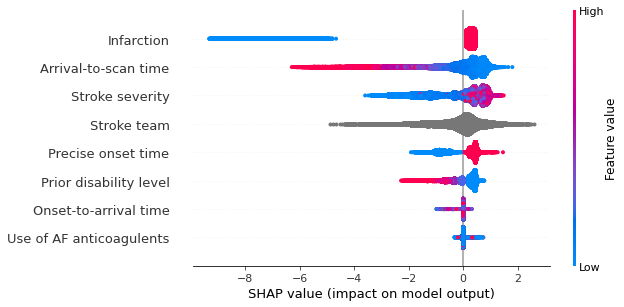

In [19]:
shap.plots.beeswarm(shap_values_combined,show=False)

Boxplot per categorical variable showing the spread of SHAP values for each categorical level.

Taking the single feature (Stroke team) and showing the sum of all the hospitals SHAP values by classifying it as the hosptial the patient attended. So this shows the SHAP of "attending this hospital and not the others".

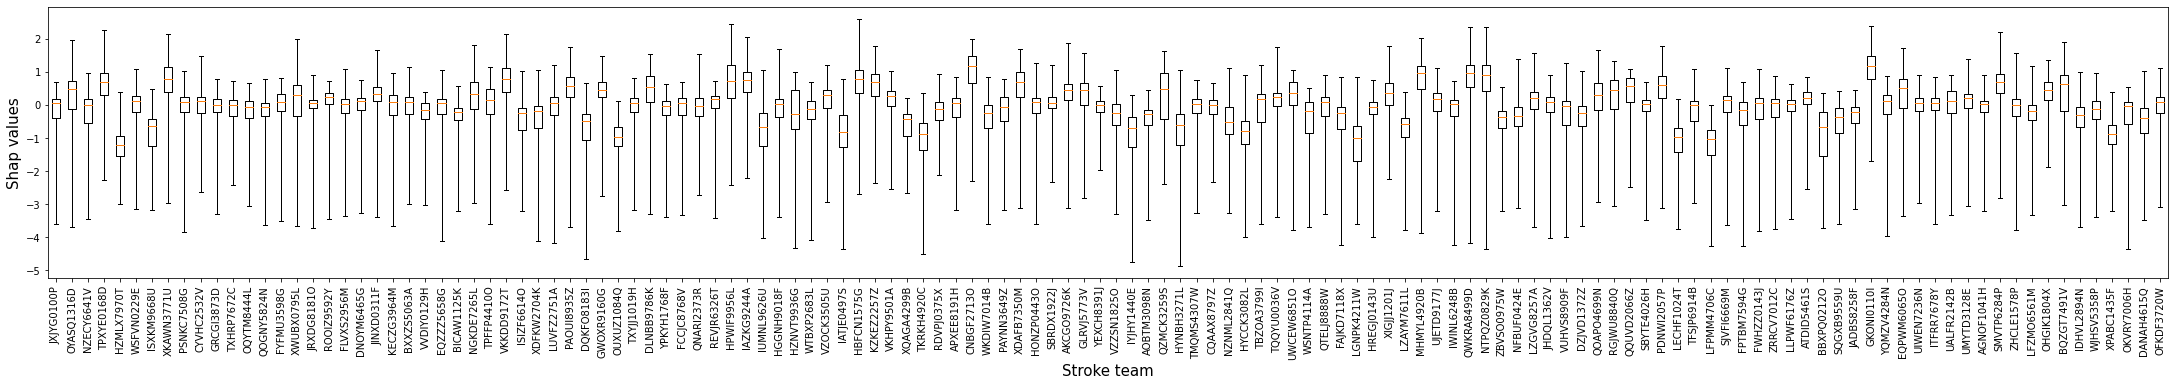

In [20]:
#get shaply values and data
stroketeam_values = shap_values_combined[:,"Stroke team"].values
stroketeam_data = shap_values_combined[:,"Stroke team"].data

#split odor shap values based on odor category
stroketeam_categories = list(set(stroketeam_data))

stroketeam_groups = []
for o in stroketeam_categories:
    relevant_values = stroketeam_values[stroketeam_data == o]
    stroketeam_groups.append(relevant_values)

#plot boxplot
plt.figure(figsize=(38, 5))

plt.boxplot(stroketeam_groups,labels=stroketeam_categories,whis=100)

plt.ylabel('Shap values',size=15)
plt.xlabel('Stroke team',size=15)
plt.xticks(rotation=90)
plt.show()
#plt.savefig(path.format('boxplot.png'),dpi=100,bbox_inches='tight')

Show SHAP values for each level of the Stroke team feature, showing 35 teams per plot, sorted in order of lowest admission levels first.

Taking the single feature (Stroke team) and showing the sum of all the hospitals SHAP values by classifying it as the hosptial the patient attended. So this shows the SHAP of "attending this hospital and not the others".

Summing the SHAP values for the hospital one hot encoded features into a single value. 
Here they are represented based on the hospital that the patient attended. 
Doing so represents the contribution to the prediction for attending this hospital, and not the others
(Hospital admission numbers brackets)


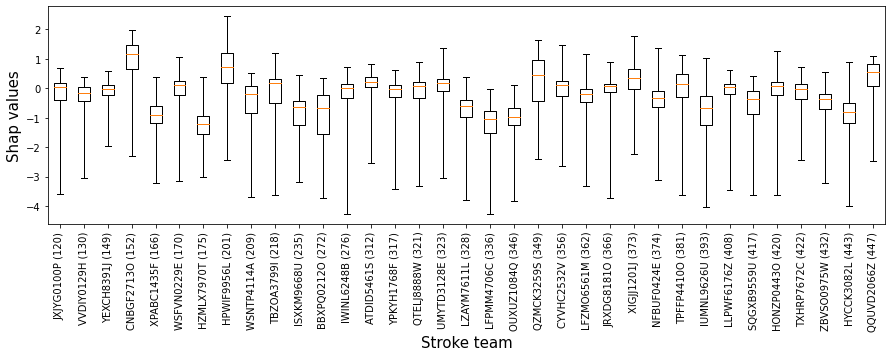

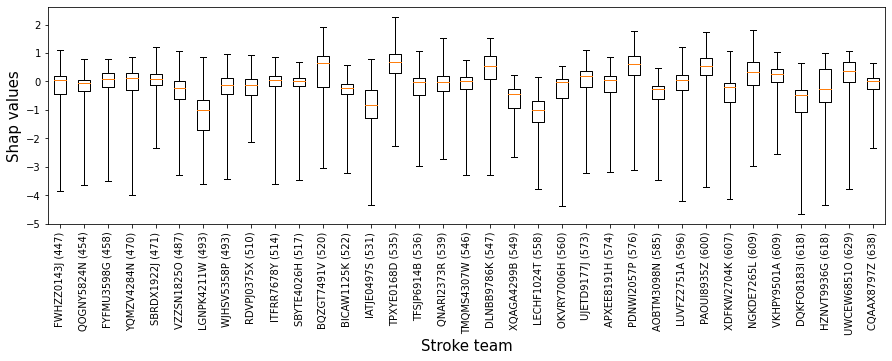

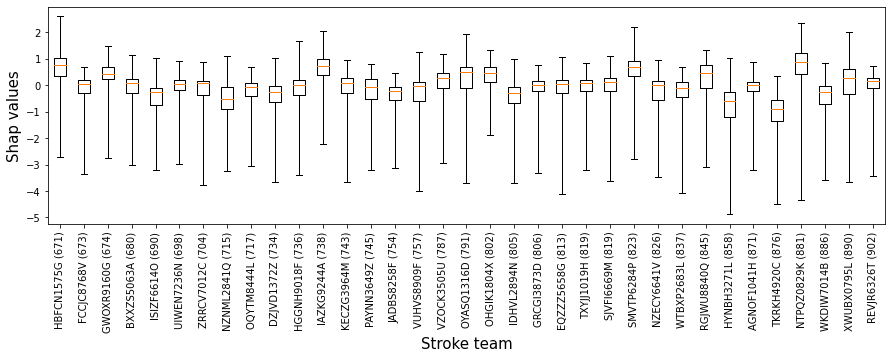

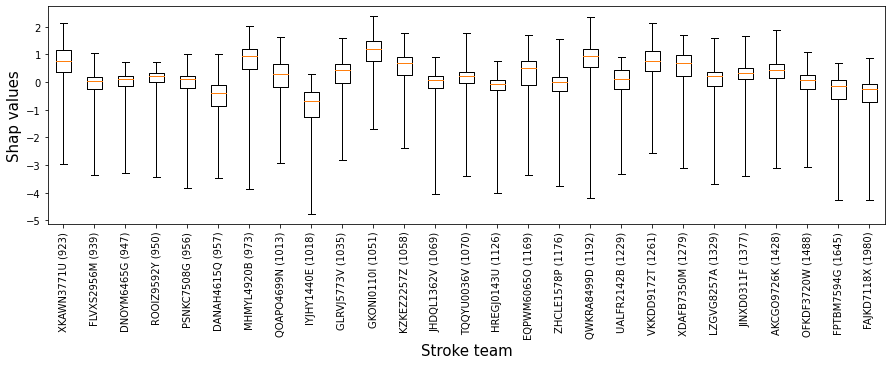

In [90]:
# Get SHAP values and data for feature Stroke Team (a categorical feature). Value per instance.
stroketeam_values = shap_values_combined[:,"Stroke team"].values
stroketeam_data = shap_values_combined[:,"Stroke team"].data

# Group data by stroke team.
# Get Stroke team name, the stroke team admission numbers, and list of SHAP values for each instance that attended teh stroke team
stroketeam_categories = list(set(stroketeam_data))
admissions = [X[f'team_{o}'].sum() for o in stroketeam_categories]
stroketeam_groups = [stroketeam_values[stroketeam_data == o] for o in stroketeam_categories]

# Determine order of boxplots by admission values (highest to lowest)
rank_order_admissions = ss.rankdata(admissions)

# Initialise lists
# Populate with the data for the Stroke teams, put in order of admissions, from lowest to highest
stroketeam_groups1 = []
stroketeam_admissions1 = []
stroketeam1 = []
xlabel = []

prev = 99
for j in np.sort(rank_order_admissions):
    if j != prev:
        index1 = np.where(rank_order_admissions == j)
        for i in index1[0]:
            stroketeam_groups1.append(stroketeam_groups[i])
            stroketeam_admissions1.append(admissions[i])
            stroketeam1.append(stroketeam_categories[i])
            xlabel.append(f'{stroketeam_categories[i]} ({admissions[i]})')
    prev = j

# Create boxplots with 35 stroke teams in each
print("Summing the SHAP values for the hospital one hot encoded features into "
      "a single value. \nHere they are represented based on the hospital that "
      "the patient attended. \nDoing so represents the contribution to the "
      "prediction for attending this hospital, and not the others")
print("(Hospital admission numbers brackets)")
st = 0
ed = 35
inc = ed
max_size = len(stroketeam_groups1)
for i in range(4):
    #plot boxplot
    plt.figure(figsize=(15, 4))
    plt.boxplot(stroketeam_groups1[st:ed],labels=xlabel[st:ed],whis=100)
    plt.ylabel('Shap values',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

## Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature).

In [22]:
%%time

filename = f'./output/12a_xgb_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    # Get SHAP interaction values
    shap_interaction = explainer.shap_interaction_values(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_interaction, filehandler)

CPU times: user 15 ms, sys: 2.62 s, total: 2.63 s
Wall time: 6.75 s


SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 891 instances has a 4x4 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [23]:
shap_interaction.shape

(88792, 139, 139)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [24]:
shap_interaction[0]

array([[ 6.5910852e-01,  4.2939126e-02,  2.8695703e-02, ...,
        -2.4725590e-04,  1.9933996e-04, -9.9656335e-04],
       [ 4.2939067e-02,  3.1778699e-01,  4.6772063e-02, ...,
         7.2282273e-07,  0.0000000e+00,  1.1991942e-06],
       [ 2.8695643e-02,  4.6772093e-02,  7.7302808e-01, ...,
        -3.1074975e-05,  5.7468645e-04,  7.5616292e-05],
       ...,
       [-2.4724007e-04,  7.1525574e-07, -3.1054020e-05, ...,
         2.3201099e-03,  0.0000000e+00,  0.0000000e+00],
       [ 1.9934773e-04,  0.0000000e+00,  5.7467818e-04, ...,
         0.0000000e+00, -2.4604283e-03,  0.0000000e+00],
       [-9.9658966e-04,  1.2069941e-06,  7.5638294e-05, ...,
         0.0000000e+00,  0.0000000e+00,  3.5439148e-03]], dtype=float32)

Represent the shap-interactions without one-hot encoded features (that is to represent Embarked as a single column by summing the relevant OHE)

In [25]:
# Want to do a culmulative sum on the SHAP interactions for each instance. 
# Need to know how many one-hot features there are per feature.
# So store the number of categories for each feature, apart from the final feature (as this will take the rest).
# If it's continuous feature, then have value 1.
#  Want result [1,1,1].

n_categories = []

for c in list(X_combined.columns):
    if  X_combined[c].dtype == object:
        n_categories.append(X_combined[c].nunique())
    else:
        n_categories.append(1)

Represent the shap_interaction.values as a value per feature (sum up the one-hot encoded features).

In [26]:
def sum_matrix_elements(matrix, n_categories):
    
    '''
    # Here are three examples to show what this function does.
    
    1. Start with a 3x3 matrix

    matrix = np.array([[1,2,3],[4,5,6],[7,8,9]])

    If define the first group to have 1 column, and second group to have 2 columns
    n_categories = [1,2]

    # Want result to be a 2x2 matrix, such that:
    m_result = np.array[[1,2+3],[4+7,5+6+8+9]]
    m_result = np.array[[1,5],[11,28]]

    2. Start with a 3x3 matrix

    matrix = np.array([[1,2,3],[4,5,6],[7,8,9]])

    If define the first group to have 2 columns, and second group to have 1 column
    n_categories = [2, 1]

    # Want result to be a 2x2 matrix, such that:
    m_result = np.array[[1+2+4+5,3+6],[7+8,9]]
    m_result = np.array[[12,9],[15,9]]

    3. Start with a 4x4 matrix

    matrix = np.array([[1,2,3,4],[5,6, 7, 8],[9,10,11,12],[13,14,15,16]])
    
    If define the first group to have 2 columns, and second group to have 2 columns
    n_categories = [2,2]

    # Want result to be a 2x2 matrix, such that:
    m_result = np.array[[1+2+5+6,3+4+7+8],[9,10,13,14],[11,12,15,16]]
    m_result = np.array[[14,22],[46,54]]

    '''
    
    #initialise matrix result
    m_result = np.zeros((len(n_categories), len(n_categories)))

    end_r = 0
    new_r = 0
    
    # go through the rows in the groups as determined in the n_categories
    for r in n_categories:
        # New block of rows, so start from the first column
        new_c = 0
        end_c = 0
        #Set start row to the end of the previous group
        start_r = end_r
        #and the end row to the number of rows as defined by the number in the group
        end_r = (start_r + r)

        # go through the rows in the groups as determined in the n_categories
        for c in n_categories:
            #Set start column to the end of the previous group
            start_c = end_c
            #and the end column to the number of columns as defined by the number in the group
            end_c = (start_c + c)
            #The entry is the sum of the values in the original matrix
            m_result[new_r, new_c] = matrix[start_r:end_r, start_c:end_c].sum()
            #Move column index on one (for the result matrix)
            new_c+=1
        # Move row index on one (for the result matrix)
        new_r+=1
    return(m_result)

In [27]:
#initialise matrix result
shap_interaction_combined = np.zeros((shap_interaction.shape[0], len(n_categories), len(n_categories)))

i = 0
# for each instance, get the interaction matrix
for matrix in shap_interaction:
    # combine the relevant elements of the interaction matrix (the one-hot encoded features)
    #    and store result in array
    shap_interaction_combined[i,:,:] = sum_matrix_elements(matrix, n_categories)
    i+=1

SHAP interaction values have a matrix of values (per pair of features) per instance.

In this case, each of the 891 instances has a 4x4 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions, and the fourth feature now being represented by 1 columns and not 3).

In [28]:
shap_interaction_combined.shape

(88792, 8, 8)

In [29]:
print(f"Sum of SHAP from two sources: {shap_interaction.sum().sum()} & {shap_interaction_combined.sum().sum()}")
print(f"Sum of SHAP from two sources: {shap_interaction[1].sum()} & {shap_interaction_combined[1].sum()}")

Sum of SHAP from two sources: -134835.4375 & -134835.05720020126
Sum of SHAP from two sources: 1.8863579034805298 & 1.8863582193735056


### SHAP interaction matrix: show mean absolute values
Here we see the absolute mean of the SHAP interaction values for all of the instances.\
The values on the diagonal show the main effect for the feature, and the other values show the SHAP interaction for pairs of features (these are symetrical across the diagonal)

In [30]:
mean_abs_interactions = pd.DataFrame(
    np.abs(shap_interaction_combined).mean(axis=(0)),
    index=X_combined.columns, columns=X_combined.columns)

mean_abs_interactions.round(2)

Arrival-to-scan time  Infarction  Stroke severity  \
Arrival-to-scan time                      0.95        0.09             0.08   
Infarction                                0.09        1.43             0.09   
Stroke severity                           0.08        0.09             0.86   
Precise onset time                        0.03        0.06             0.05   
Prior disability level                    0.03        0.04             0.04   
Stroke team                               0.10        0.04             0.08   
Use of AF anticoagulents                  0.00        0.00             0.00   
Onset-to-arrival time                     0.00        0.00             0.00   

                          Precise onset time  Prior disability level  \
Arrival-to-scan time                    0.03                    0.03   
Infarction                              0.06                    0.04   
Stroke severity                         0.05                    0.04   
Precise onset time                      0.58                    0.03   
Prior disability level                  0.03                    0.41   
Stroke team                             0.05                    0.04   
Use of AF anticoagulents                0.00                    0.00   
Onset-to-arrival time                   0.00                    0.00   

                          Stroke team  Use of AF anticoagulents  \
Arrival-to-scan time             0.10                      0.00   
Infarction                       0.04                      0.00   
Stroke severity                  0.08                      0.00   
Precise onset time               0.05                      0.00   
Prior disability level           0.04                      0.00   
Stroke team                      0.56                      0.00   
Use of AF anticoagulents         0.00                      0.01   
Onset-to-arrival time            0.00                      0.00   

                          Onset-to-arrival time  
Arrival-to-scan time                       0.00  
Infarction                                 0.00  
Stroke severity                            0.00  
Precise onset time                         0.00  
Prior disability level                     0.00  
Stroke team                                0.00  
Use of AF anticoagulents                   0.00  
Onset-to-arrival time                      0.01

### The proportion of SHAP that is from the interactions: calculated from the absolute mean
Looking at all of the instances together, what proportion of the SHAP value comes from the SHAP interations

In [31]:
total_shap = mean_abs_interactions.sum().sum()

interaction_shap = (mean_abs_interactions.sum().sum() - 
                    np.diagonal(mean_abs_interactions).sum().sum())

print(f'The proportion of the SHAP values coming from the interactions are: '
      f'{interaction_shap/total_shap:0.3f}')
print(f'The proportion of the SHAP values coming from the main effects are: '
      f'{1 - (interaction_shap/total_shap):0.3f}')

The proportion of the SHAP values coming from the interactions are: 0.269
The proportion of the SHAP values coming from the main effects are: 0.731


### The proportion of SHAP that is from the interactions: calculated per instance from the absolute values
Looking at each instances, what proportion of the SHAP value comes from the SHAP interations. Show the range of proportions (one per instance) as a histogram.

Text(0, 0.5, 'Number of instances')

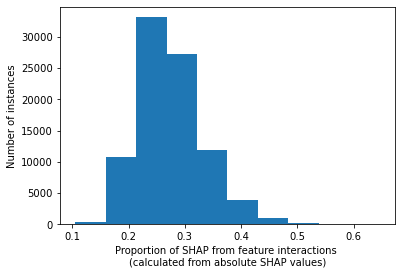

In [32]:
# sum the absolute interaction matrix per instance
abs_total_shap_per_instance = np.abs(shap_interaction_combined).sum(axis=(1,2))

# Initialise list
proportion_interaction = []

# For each instance
for i in range(abs_total_shap_per_instance.shape[0]):
    # sum the absolute feature interactions (off diagonal positions)
    abs_interaction = (abs_total_shap_per_instance[i] - 
                       np.diagonal(np.abs(shap_interaction_combined[i])).sum())
    # calculate the proportion from feature interactions
    proportion_interaction.append(
                abs_interaction / abs_total_shap_per_instance[i])

# plot as histogram
plt.hist(proportion_interaction);
plt.xlabel("Proportion of SHAP from feature interactions \n"
           "(calculated from absolute SHAP values)")
plt.ylabel("Number of instances")

### SHAP interaction matrix: represented as histograms 

Show the distribution of all of the instance values for each SHAP interation and SHAP main effect.

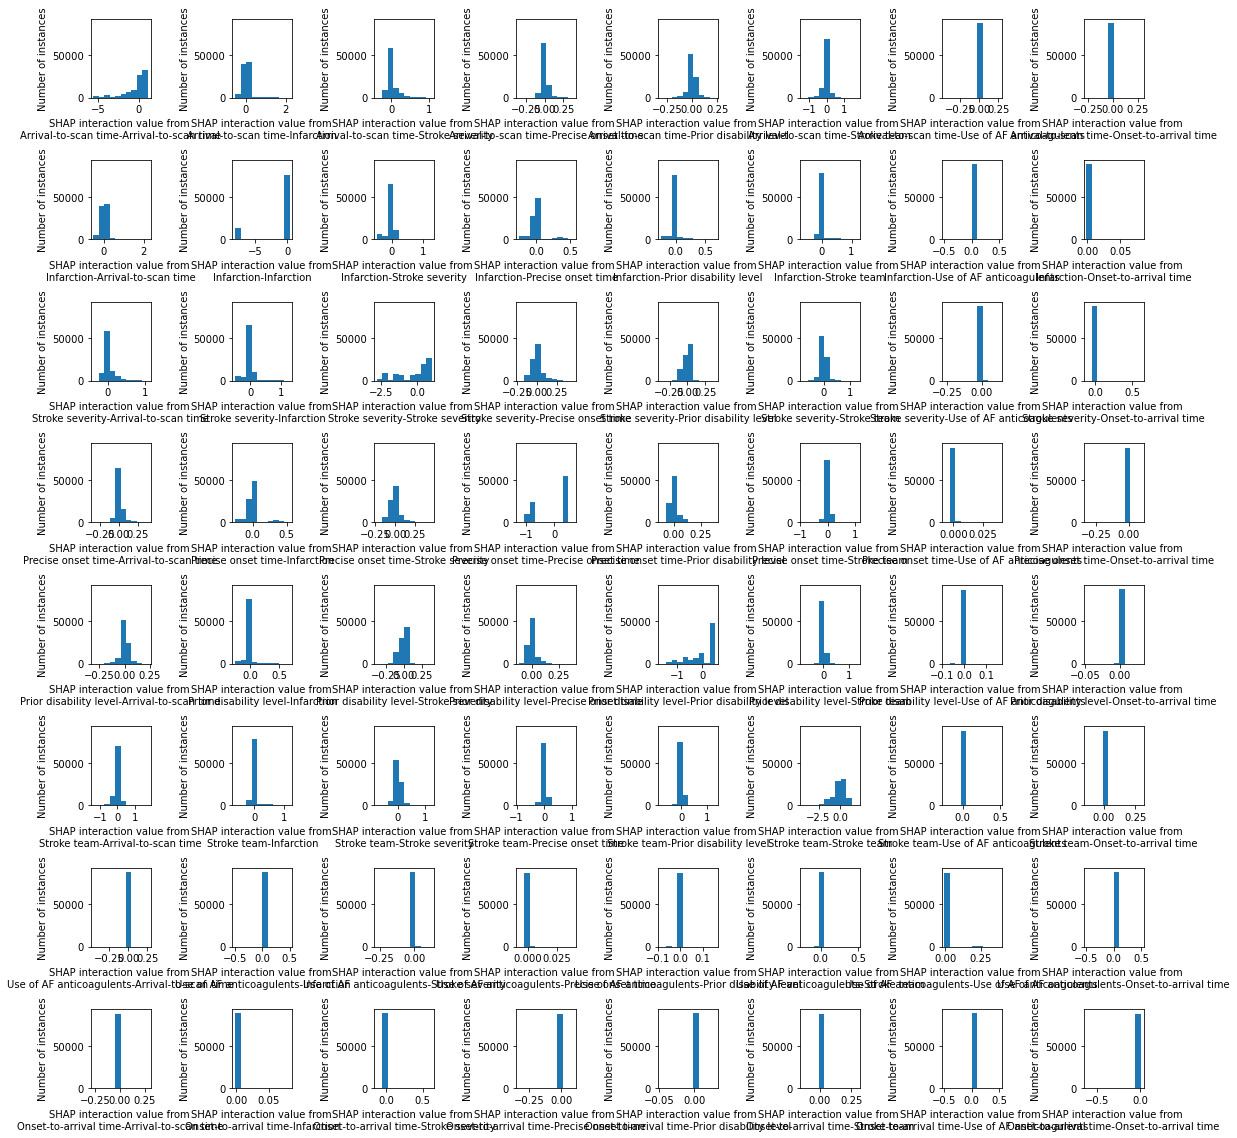

In [33]:
features = X_combined.columns
n_features = len(features)

# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
fig, axes = plt.subplots(1)
for i in range(n_features):
    for j in range(n_features):    
        axes.hist(shap_interaction_combined[:,i,j])
        ylims = axes.get_ylim()
        # Store if greater than found so far
        y_max = max(y_max, ylims[1])
# Don't display plot
plt.close(fig)

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()        

count = 0
for i in range(n_features):
    for j in range(n_features):    
        ax=axes[count]
        ax.hist(shap_interaction_combined[:,i,j])
        ax.set_xlabel(f"SHAP interaction value from \n{features[i]}-{features[j]}")
        ax.set_ylabel("Number of instances")
        ax.set_ylim(0, y_max)
        count += 1
        
fig.set_figheight(16)
fig.set_figwidth(16)
plt.tight_layout(pad=2)
#fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

## Show a worked example for the first instance
Start with the feature values, and then show the SHAP values and how they can be represented as main effect and interactions. Also show that by summing them along with the base value gives the model output.

In [34]:
instance = 0
target_category = ["not thrombolysis", "thrombolysis"]
# Show data for first example
print ('Showing a worked example for the first instance')
print ('==============================================')
print ()
print ('------------------')
print ('Feature data values')
print ('------------------')
print (X_combined.iloc[instance])

# Model output
prob_thrombolysis = y_proba[instance][1]
logodds_thrombolysis = np.log(prob_thrombolysis/(1 -prob_thrombolysis))
print ()
print ('-------------------')
print ('Model output values')
print ('-------------------')
print (f'1. Model probability [not thrombolysis, thrombolysis]: ' +
       f'{np.round(y_proba[instance],3)}')
##print ('------------')
#print (np.round(y_proba[instance],3))
print (f'\n2. Model log odds thrombolysis: {round(logodds_thrombolysis,3)}')
#print ('------------')
#print(round(logodds_survive,3))
cat = np.int(y_pred[instance])
print (f'\n3. Model classification: {cat} ({target_category[cat]})')
##print ('------------')
#print (y_pred[instance])

print ()
print ('-----------------')
print ('SHAP base value (log odds)')
print ('---------------')
print (shap_values_combined.base_values[instance])
print ('\nNote: This is the same value for all of the instances. This is the ' +
       'models best guess without additional knowledge about the instance')
 
#example_shap = pd.DataFrame(shap_values.values[instance],columns=X.columns)
print ()
print ('-----------------')
print ('SHAP values (log odds)')
print ('------------')
# print (example_shap)
for i in range(len(shap_values_combined.values[instance])):
    v = shap_values_combined.values[instance][i]
    print (f'{X_combined.columns.values[i]}: {v:0.3f}')
v = shap_values_combined.values[instance].sum()
print (f'Total = {v:0.3f}')

print ('\nNote: These are patient dependent')
#print ()
#print ('-----------------')
#print ('Sum of SHAP values')
#print ('------------')
#print (shap_values.values[instance].sum())

print (f'\nThe "Model log odds thrombolysis" value ({logodds_thrombolysis:0.3g}, ' +
       f'see above) is calculated by adding up the SHAP base value ' +
       f'({shap_values_combined.base_values[instance]:0.3f}, see above) with ' +
       f'all of the SHAP values for each feature ' +
       f'({shap_values_combined.values[instance].sum():0.3f}, see above)')
print (f'{shap_values_combined.base_values[instance]:0.3f} + ' +
       f'{shap_values_combined.values[instance].sum():0.3f} = ' +
       f'{logodds_thrombolysis:0.3f}')

# SHAP interaction values for first employee
example_interaction = pd.DataFrame(shap_interaction_combined[instance],
                                   index=X_combined.columns,
                                   columns=X_combined.columns)
row_total = example_interaction.sum(axis=0)
column_total = example_interaction.sum(axis=1)
total = example_interaction.sum().sum()
example_interaction['Total'] = row_total
example_interaction.loc['Total'] = column_total
example_interaction.loc['Total']['Total'] = total

print ()
print ('-----------------')
print ('SHAP interactions (log odds)')
print ('-----------------')
print ('\n* Each instance has a different SHAP value for the features. This ' +
       'is because the model is also capturing the interaction between pairs ' +
       'of features, and how that contributes to the features SHAP value.')
print ('* Each feature has a SHAP main effect (on the diagonal) and a SHAP ' +
       'interaction effect with each of the other features (off the diagonal)')
print ('* SHAP interaction is split symetrically, eg. age-male is the same ' +
       'as male-age.')
print ('* For each feature, the sum of the SHAP main effect and all of its ' +
       'SHAP interaction values = SHAP value for the feature (shown in ' +
       '"Total", and can be compared to the SHAP values above)')
print ()
print (example_interaction)

print ('------------------')
print ('\nThe model prediction for each instance can be arrived at by ' +
       'starting at the SHAP base value, and adding on the SHAP values from ' +
       'all of the the main effects (one per feature) and from all of the ' +
       'SHAP interactions (two per pair of features).')

Showing a worked example for the first instance

------------------
Feature data values
------------------
Arrival-to-scan time              17.0
Infarction                           1
Stroke severity                   14.0
Precise onset time                   1
Prior disability level               0
Stroke team                 TXHRP7672C
Use of AF anticoagulents             0
Onset-to-arrival time            186.0
Name: 0, dtype: object

-------------------
Model output values
-------------------
1. Model probability [not thrombolysis, thrombolysis]: [0.147 0.853]

2. Model log odds thrombolysis: 1.757

3. Model classification: 1 (thrombolysis)

-----------------
SHAP base value (log odds)
---------------
-1.0995926

Note: This is the same value for all of the instances. This is the models best guess without additional knowledge about the instance

-----------------
SHAP values (log odds)
------------
Arrival-to-scan time: 0.821
Infarction: 0.456
Stroke severity: 0.924
Precise onset t

## Sum of the SHAP value components (base + main effects + interactions) = model prediction 
We've seen a worked through example for one instance that the sum of the SHAP interactions and main effects and base value equals the model output (the log odds of predicted P). 

Here we show that it holds for all of the instances.

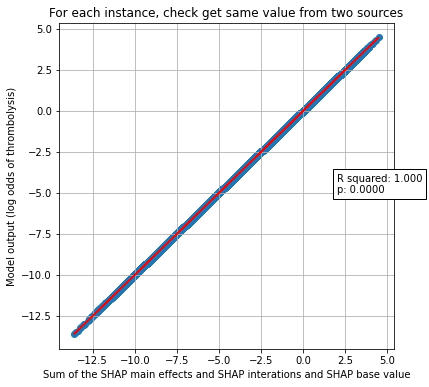

In [35]:
# Model output: probability thrombolysis
prob_thrombolysis = y_proba[:,1]
# Calculate log odds
logodds_thrombolysis = np.log(prob_thrombolysis/(1 -prob_thrombolysis))

# sum each matrix to get a value per instance
total_shap_per_instance = shap_values_combined.base_values + shap_interaction_combined.sum(axis=(1,2))

x = total_shap_per_instance
y = logodds_thrombolysis

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(2, -5, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel("Sum of the SHAP main effects and SHAP interations and SHAP base value")
ax1.set_ylabel("Model output (log odds of thrombolysis)")
plt.title("For each instance, check get same value from two sources")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

# Histogram of total SHAP

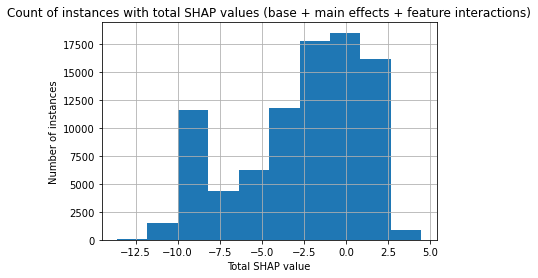

In [36]:
plt.hist(total_shap_per_instance)
plt.xlabel("Total SHAP value")
plt.ylabel("Number of instances")
plt.title("Count of instances with total SHAP values (base + main effects + feature interactions)")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

## How the SHAP main effect (or interaction) varies across the instances: using violin plots

### SHAP main effect of Infarction-Infarction

For this example lets focus on the feature "Infarction". This feature has two possible values: Infarction (1) and Haemorrhage (0).

From the histogram in the matrix showing the main effect for the feature Infarction, we can see that there are ~?? instances with a main effect of about 0.1, and ~?? instances with a main effect of about -7.

From this we can not see which of these instances are which stroke type (infarction of haemmorhage).

Here we will plot this same data using a violin plot, a violin for each streok type.

We can see from the violin plot that the main effect (infarction-infacrtion) is quite different depending on whether the instance is haemorrhage (a negative SHAP main effect value) or infarction (a positive SHAP main effect value).

This means that the feature will contribute a small likelihood of thrombolysis if the instance is infarction, and a strong likelihood of not having thrombolysis if the instance is haemorrhage. This matches the story that we took from the beeswarm plot of the SHAP values, however as we have now extracted just the main effect the violin plot is showing a distinct effect for gender. That means that the points on the beeswarm that join up these two distinct groups are from the feature interactions - they "muddy" the relationship (blur the edges, say) between the feature value and SHAP value. 

In [37]:
def plot_violin_shap_interaction(X, shap_interaction, main_feature, 
                                 interaction_feature):
    """
    Given the two features (main_feature and interaction_feature), plot the SHAP 
    interations as violin plots. 
    The main_feature will have it's data values displayed on the x axis. 
    The interaction_feature determines the SHAP interaction values that are 
    displayed in the violins.
    If the same feature name is in both (main_feature and interaction_feature)
    then the main effect will be displayed.
    
    X [pandas dataframe]: Feature per column, instance per row
    shap_interaction [3D numpy array]: [instance][feature][feature]
    main_feature [string]: feature name
    interaction_feature [string]: feature name
    
    """
    # Get the unqiue categories for the main feature
    category_list = list(X[main_feature].unique())

    # Setup dictionary and keys (key for each category, each key will hold a 
    #   list of SHAP interaction values for that category)
    shap_interaction_by_category_dict = {}
    for i in category_list:
        shap_interaction_by_category_dict[i]=[]
    
    # Store number of instances and number of categories
    n_instances = X.shape[0]
    n_categories = len(category_list)
    
    # For each instance put its instance interaction value in the corresponding 
    #   list (based on the instances category for the main feature)
    for i in range(n_instances):
        # Identify the instances category for the main feature
        category = X.iloc[i][main_feature]

        # Get the SHAP interaction value for the instance
        instance_interaction = pd.DataFrame(
            shap_interaction[i],index=X.columns,columns=X.columns)
        
        # Get the feature pairing interaction value
        value = instance_interaction.loc[main_feature][interaction_feature]

        # Store value in the dictionary using category as the key
        shap_interaction_by_category_dict[category].append(value)
    
    # Set violin width relative to count of instances
    width = [(len(shap_interaction_by_category_dict[category])/n_instances) 
             for category in category_list]

    # Create list of series to use in violin plot (one per violin)
    shap_per_category = [pd.Series(shap_interaction_by_category_dict[category]) 
                         for category in category_list]
    
    # create violin plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.violinplot(shap_per_category, showmedians=True, widths=width, )

    # customise the axes
    ax.set_title("")
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=90, fontsize=12)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(
        f'SHAP interaction value for {main_feature}-{interaction_feature}',
        fontsize=12)
    ax.set_xlabel(f'Feature: {main_feature}', fontsize=12)

    plt.subplots_adjust(bottom=0.15, wspace=0.05)

    # Add line at Shap = 0
    ax.plot([0, n_categories + 1], [0,0],c='0.5')
    
    return()

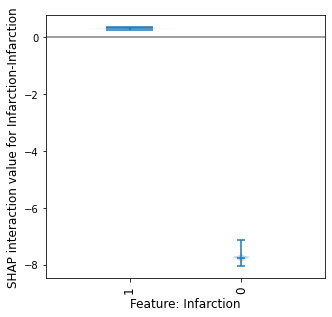

In [38]:
plot_violin_shap_interaction(X_combined, shap_interaction_combined, "Infarction", "Infarction");

### SHAP interaction of Infarction-precise

We can also see the range of the SHAP interaction value between the features male-Pclass (divided by the male categories).

This shows that for females the SHAP interaction value between male-Pclass ranges from -0.6 to 0.9, and for males it has a smaller range (-0.6 to 0.3). Since this is in addition to the main effect (for which all females had a strong likelihood to survive), for some females their likelihood for surviving is further increased, whereas for others their likelihood for surviving is reduced - but never enough to have a likelihood of not surviving. Remember that we'd need to add on all of the other SHAP interations to get the likelihood of surviving for females.

()

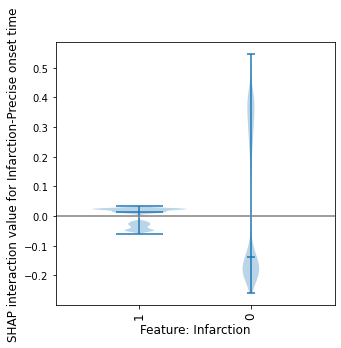

In [39]:
plot_violin_shap_interaction(X_combined, shap_interaction_combined, "Infarction", "Precise onset time")#"Arrival-to-scan time");

Violin plots can only display the values for one of the features in a feature-pairing - by it's placement on the x axis. In the violin plot above we can only see the value for the feature male, but not the value for the feature Pclass.

This can be solved by using a SHAP dependency plot - they can show the values for both features and the SHAP interaction value. This is shown in the following section, and we will introduce them using the same data as used in these two violin plots.

## How the SHAP main effect (or interaction) varies across the instances: using dependence plots

### SHAP main effect of infarction-infarction

We can see from the violin plot that the main effect (infarction-infarction) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

This means that the feature will contribute a strong likelihood of survival if the instance is female, and a mid-strong likelihood of not surviving if the instance is male.

A dependence plot of the same data that's in the violin plot will represent it as individual points, instead of as a distribution. Doing so, it will plot all of the points on two points on the x axis: 0 for female, and 1 for male. A lot of information is lost due to overlap. To see more detail we add some jitter to the x-axis to spread the points out and so we cna get a sense of the density of the points in relation to the y value.

Here we see the same information as in the violin plot: the main effect (male-male) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

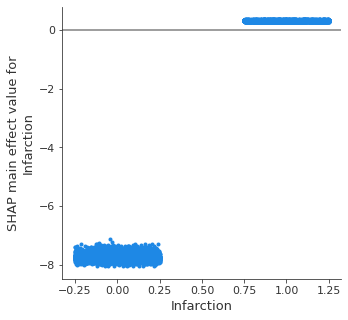

In [40]:
feature_name = "Infarction"

fig = plt.figure()
ax = fig.add_subplot()
shap.dependence_plot(
    (feature_name, feature_name),
    shap_interaction_combined, X_combined,
    display_features=X_combined,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X[feature_name].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(5)

plt.show()

### SHAP interaction of Infarction-Precise

A hinderence of using a violin plot to show the data for the SHAP interaction of a feature pair is that we can only show one of the feature values (on the x axis). 

When using a dependence plot to show the data for the SHAP interaction of a feature pairing we can display both of the feature values: the point location on the x axis shows the value of one of the features, and the colour of the point shows the value of the other feature.

Note: The SHAP interaction for feature pairings (e.g. male-Pclass) is splt between male-Pclass and Pclass-male. The total SHAP interaction is therefore 2* the individual interactions. We could multiply the interation by 2 to get the full SHAP interaction. Here we will plot both permutations and acknowledge that it's the sum of the pair (LHS shows columns as male and colour as Pclass. RHS shows columns as Pclass and colour as male). Each graph contains the exact same data points, and it is possible to match up the identical block of data points across the graphs. For example the purple points in the LHS graph represent the Pclass 2, and we can see that for these points they have a positive SHAP interaction value for female (x-axis 0) and negative SHAP interaction value for male (x-axis 1). We can see these two blocks of purple points in the RHS graph, with both blocks now aligned on the x-axis with value 2, and now coloured blue for female (with positive SHAP interaction value) or red for male (with negative SHAP interaction value).

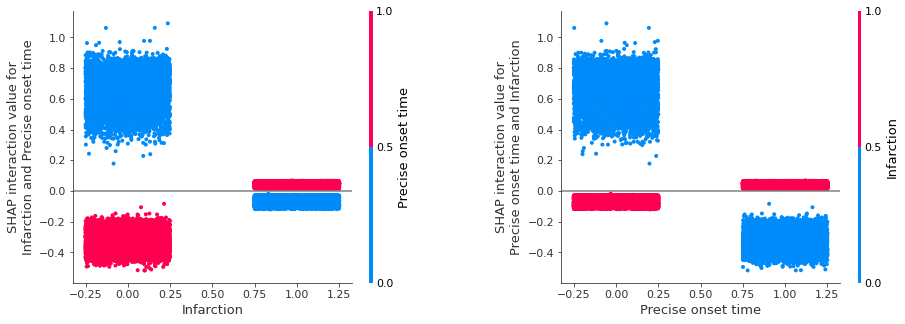

In [41]:
f1 = "Infarction"
f2 = "Precise onset time"

fig = plt.figure()
ax = fig.add_subplot(121)
shap.dependence_plot(
    (f1, f2),
    shap_interaction_combined, X_combined,
    display_features=X_combined,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X[f1].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

ax1 = fig.add_subplot(122)
shap.dependence_plot(
    (f2, f1),
    shap_interaction_combined, X_combined,
    display_features=X_combined,
    x_jitter=0.5,
    ax=ax1,
    show=False)

# Add line at Shap = 0
n_violins = X[f2].nunique()
ax1.plot([-1, n_violins + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=.4)

plt.show()

## Grid of SHAP dependence plots

We will now show all of the SHAP interaction values in a grid of plots: each row and column represents a feature.

The diagonal graphs show the SHAP main effect for each feature. The SHAP interactions between features are off the diagonal, these are split symetrically (eg. age-male == male-age).

The SHAP main effect for feature male is shown in the top left (position [0, 0]). As already discussed, this shows that when the feature value is female, this has a strong contribution to the models prediction that the passenger will survive. And when this feature value is male there is a mid-strong contribution that the passenger will not survive.

The plot in position [1,1] shows the SHAP main effect for class. This shows that first class contributes a strong likelihood to survive, second class does not have much contribution, and third class contributes a strong likelihood not to survive.

But on top of these main effects we can see the contributon from the interation of these features. This is shown in positions [0, 1] and [1, 0]. The SHAP interaction between male and Pclass, and Pclass and male.

Graph in grid position [0, 1] (first row, second column) shows the SHAP interaction between male and Pclass, the data has been split into columns by the value of the gender feature (female on left, male on right), and the colour represents the class feature (first class = blue, second class = purple, third class = red). The value represents the contribution to the likelihood of this passenger surviving due to this combination of values - this is in addition to the main effect that we saw in the top left.

It can be seen that passengers in first or second class further increase the likelihood of survival for females, and not surviving for males, as the SHAP interation value is in the same sign to the SHAP main effect: A female passenger in first or second class will increase the likelihood of survival from the models prediction, and so will further help your survival in addition to the fact that you are female (as we saw in the SHAP main effect); similarly a male passenger in first or second class will increase the likelihood of not surviving, and so will further contribute to the likelihood that you will not survive, in addition to the fact that you are male (as we saw in the SHAP main effect).
However the converse is true for passengers in third class, as the SHAP interaction value is in the opposite sign to the SHAP main effect. A female passenger in third class will have a negative contribution to the survival (but remember that the main effect for female is a strong likelihood to survive), and if you are male in third class this combination will have a positive contribution to your survival (but remember that the main effect for male is a mid-strong likelihood to not survive).

The grid of dependency graphs are a mirror image across the diagonal. Meaning that the same data is shown in position [0,1] as in [1,0] just with the feature being displayed in the column or by colour is switched over.

Looking at the graph in position [1, 0] (second row, first column) shows the identical SHAP interation values for the features male - PClass, as we have just discussed above. Now the columns are per class (first, second, third) and the colour is by gender (male, female). Here we see that for first and second class females contributes that there is a mid likelihood to not survive, whereas if male then contributes a positive likelihood to survive. But that this is opposite for third class, where is it the females (red) with a positive likelihood to survive. This is also on top of the main effect from Pclass.

Resources used to make the grid of dependence plots: https://stackoverflow.com/questions/58510005/python-shap-package-how-to-plot-a-grid-of-dependence-plots \
(for future reference, but not yet used here: https://gist.github.com/eddjberry/3c1818a780d3cb17390744d6e215ba4d)

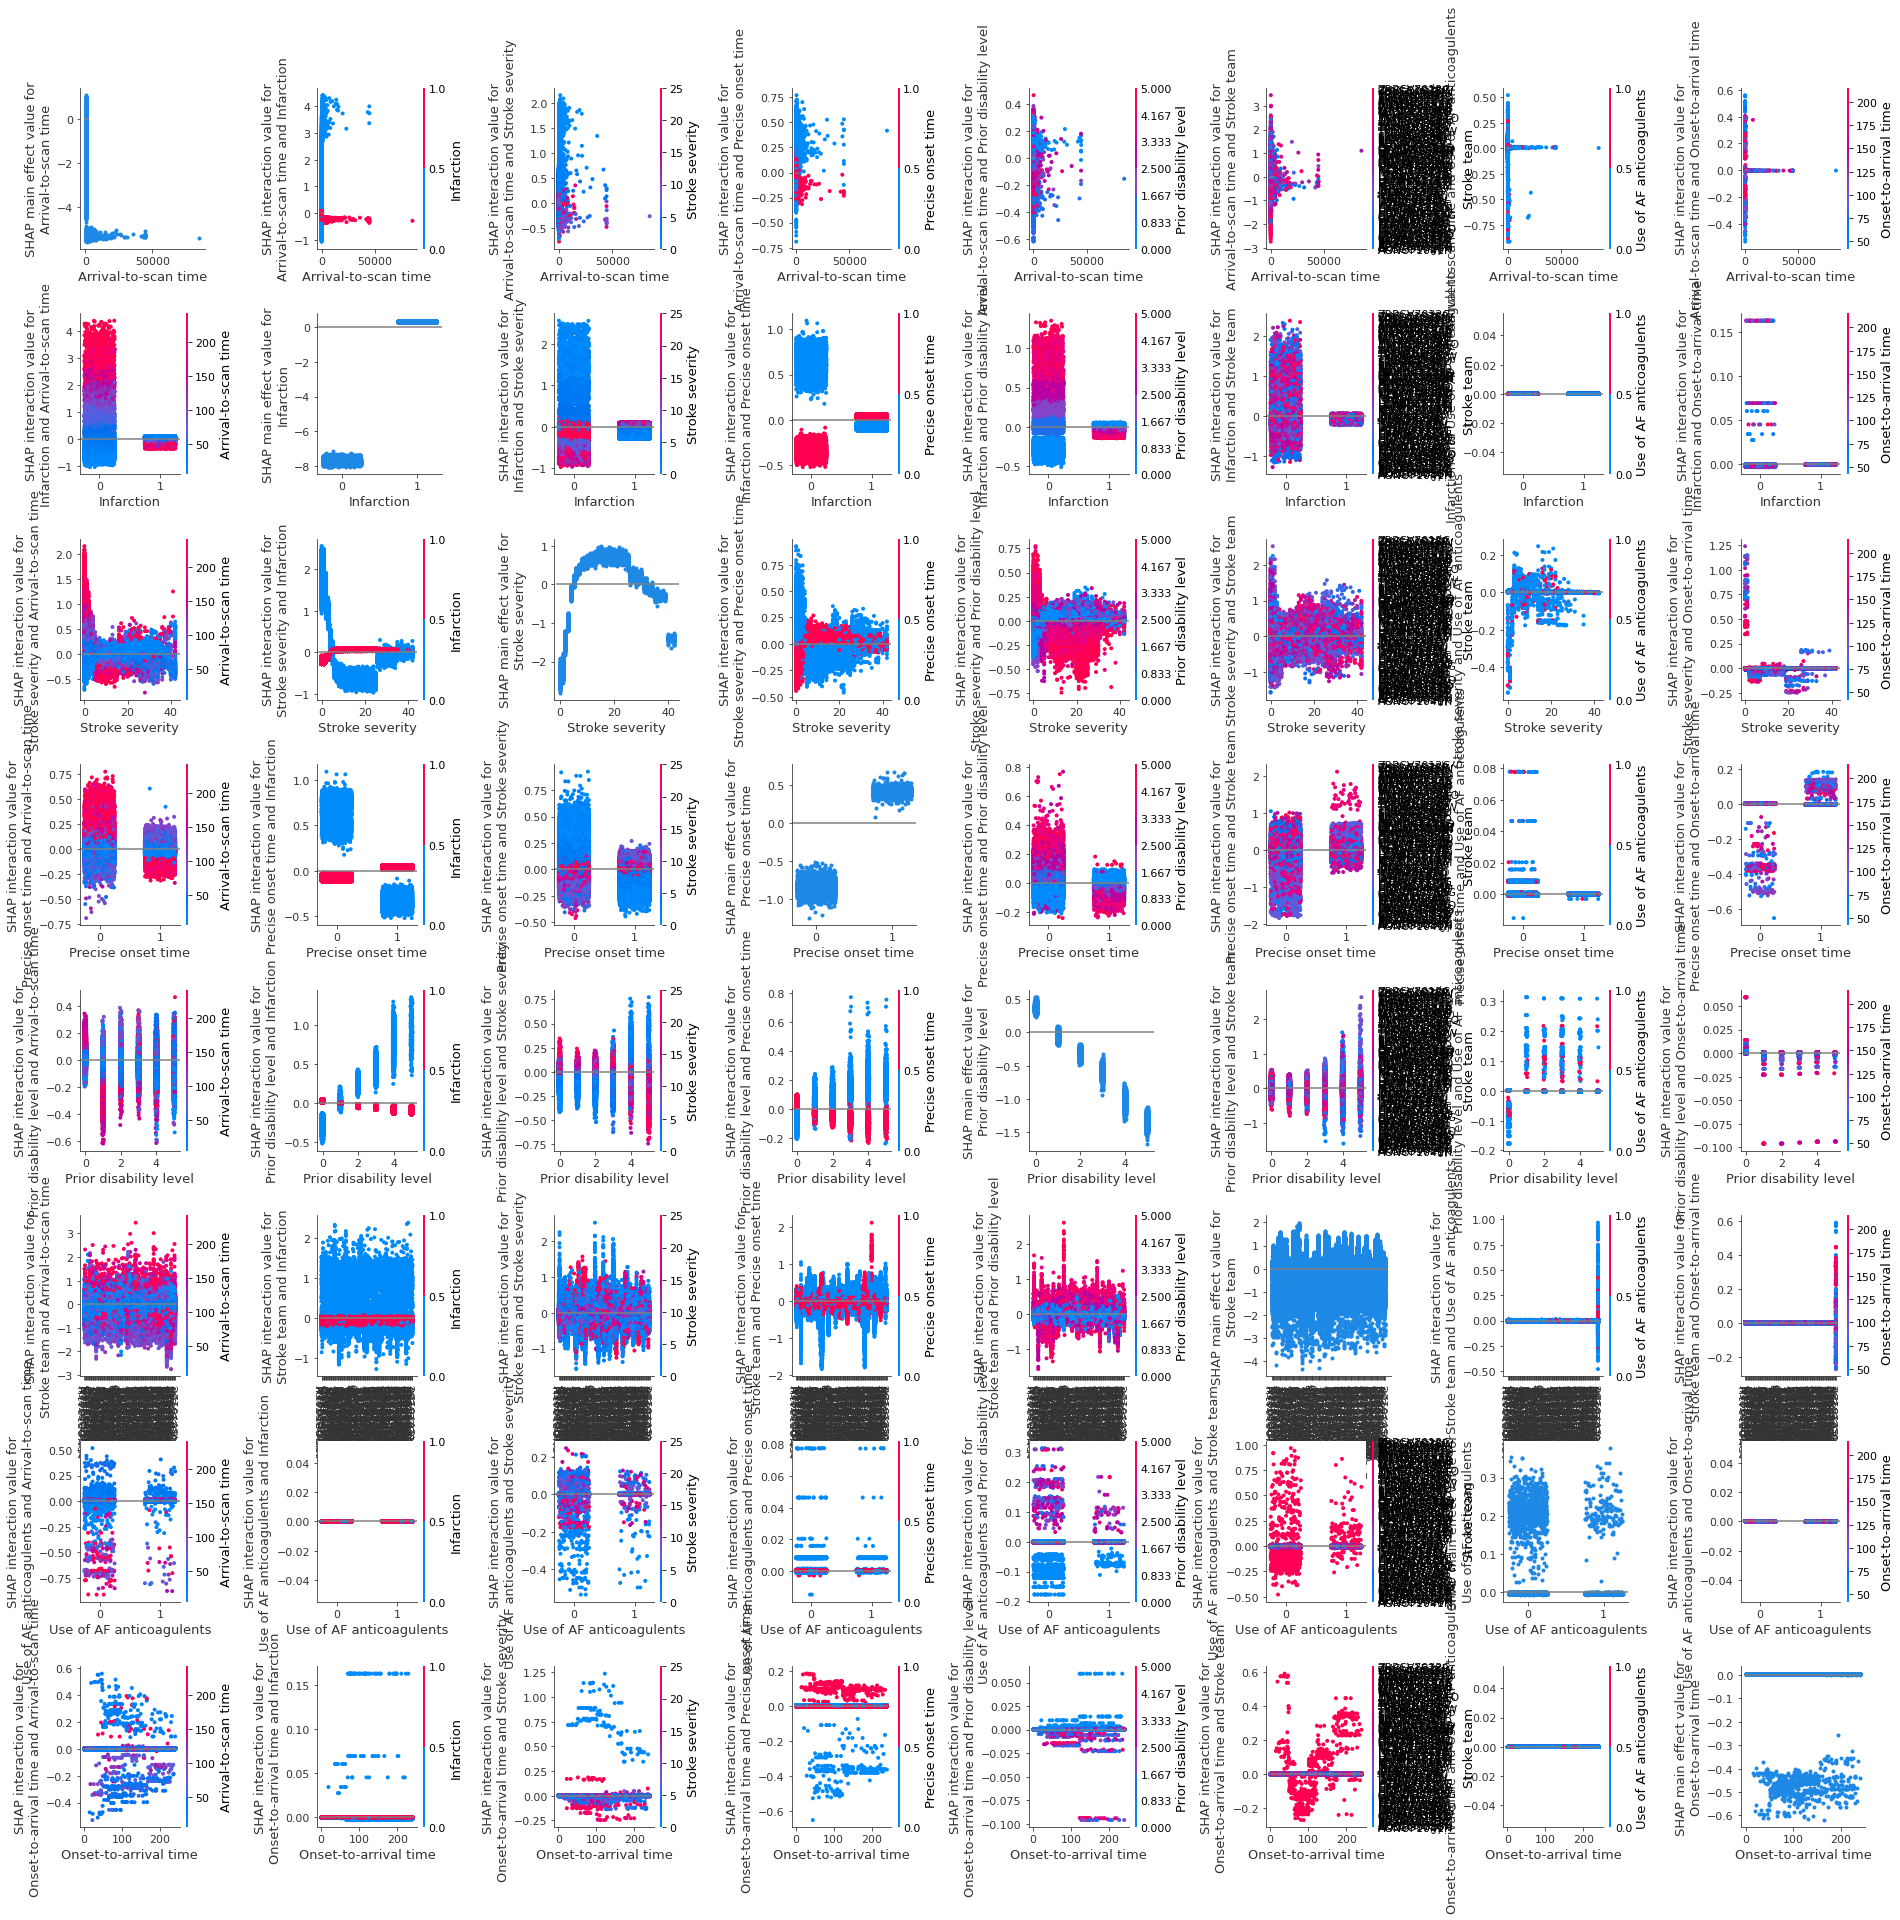

In [42]:
# Get feature names
features = X_combined.columns

# Set up the matrix of subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()

# Plot each SHAP independence (and main effect on diagonal)
count = 0
for f1 in features:
    for f2 in features:
        
        # Add more jitter the fewer categories the feature has
        n_categories = X_combined[f1].nunique()
        x_jitter = max(0, 0.7 - (n_categories * 0.1))
            
        # Plot data
        shap.dependence_plot(
            (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
            display_features=X_combined, show=False, ax=axes[count])
        
        # Add line at Shap = 0
        n_classes = X_combined[f1].nunique()
        axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
        count += 1

# Visual properties of figure
dimension = 4 * n_features
fig.set_figheight(dimension)
fig.set_figwidth(dimension)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

Just plot main effect of Arrival-Arrival, and limit x axis to 1000 minutes

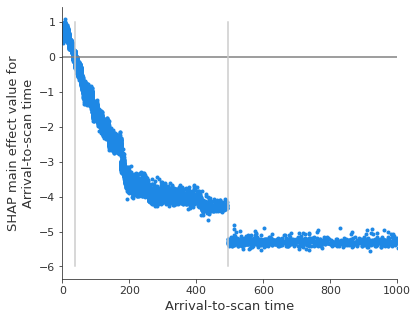

Break in SHAP values is at 8.216666666666667 hours
SHAP values are negative beyond 0.6 hours


In [43]:
# Definte x limit
xmax = 1000

# Set up figure
fig, ax = plt.subplots(figsize=(8,8))

# Choose features
f1 = "Arrival-to-scan time"
f2 = "Arrival-to-scan time"

# Add more jitter the fewer categories the feature has
n_categories = X_combined[f1].nunique()
x_jitter = max(0, 0.7 - (n_categories * 0.1))

# Plot data
shap.dependence_plot(
    (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
    display_features=X_combined, show=False, ax=ax)

# Add line at Shap = 0
n_classes = X_combined[f1].nunique()
ax.plot([-1, n_classes + 1], [0,0],c='0.5')

# Add line at break in values
break_value = 493
n_classes = X_combined[f1].nunique()
ax.plot([break_value,break_value], [-6,1],c='0.8')

# Add line at break in values
crosses_zero = 36
n_classes = X_combined[f1].nunique()
ax.plot([crosses_zero,crosses_zero], [-6,1],c='0.8')

ax.set_xlim(0, xmax)

plt.show()

print (f"Break in SHAP values is at {break_value/60} hours")
print (f"SHAP values are negative beyond {crosses_zero/60} hours")

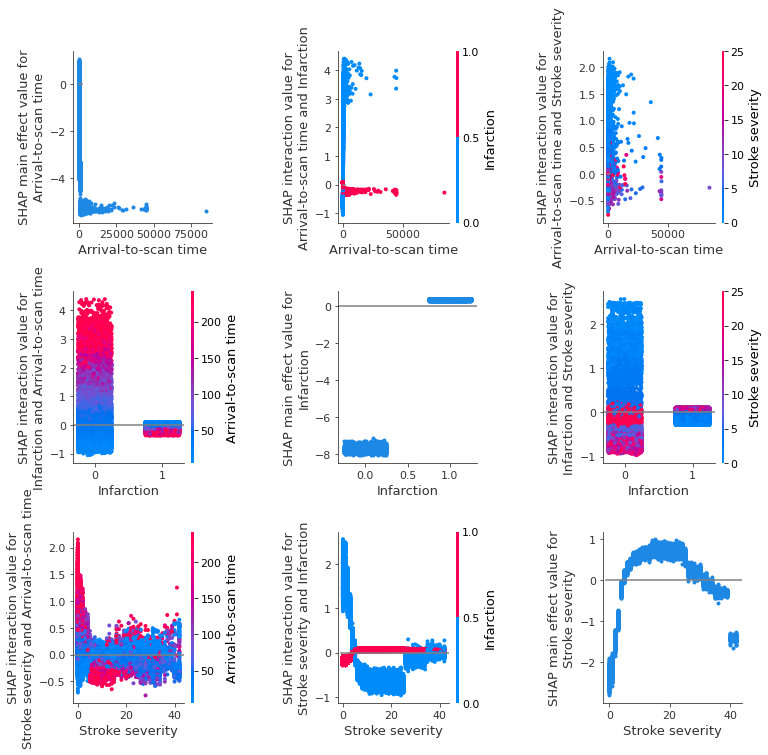

In [44]:
# Number of features to display
n = 3

# Get feature names
features = X_combined.columns[0:n]

# Set up the matrix of subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()

# Plot each SHAP independence (and main effect on diagonal)
count = 0
for f1 in features:
    for f2 in features:
        
        # Add more jitter the fewer categories the feature has
        n_categories = X_combined[f1].nunique()
        x_jitter = max(0, 0.7 - (n_categories * 0.1))
            
        # Plot data
        shap.dependence_plot(
            (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
            display_features=X_combined, show=False, ax=axes[count])
        
        # Add line at Shap = 0
        n_classes = X_combined[f1].nunique()
        axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
        count += 1

# Visual properties of figure
dimension = 4 * n
fig.set_figheight(dimension)
fig.set_figwidth(dimension)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

Check that when obtain the SHAP interaction value, have the right one

In [45]:
def range_shap_interation(f1, f2):
    # location of the two features
    f1_loc = X_combined.columns.tolist().index(f1)
    f2_loc = X_combined.columns.tolist().index(f2)

    # min and max of this interaction across all the patients
    mn = shap_interaction_combined[:,f1_loc, f2_loc].min()
    mx = shap_interaction_combined[:,f1_loc, f2_loc].max()

    # Report it out
    print (f"SHAP interaction {f1} & {f2} range: {round(mn,2)} to {round(mx,2)}")
    
    return()

In [46]:
for f1 in features:
    for f2 in features:
        range_shap_interation(f1, f2)

SHAP interaction Arrival-to-scan time & Arrival-to-scan time range: -5.55 to 1.08
SHAP interaction Arrival-to-scan time & Infarction range: -0.53 to 2.2
SHAP interaction Arrival-to-scan time & Stroke severity range: -0.38 to 1.08
SHAP interaction Infarction & Arrival-to-scan time range: -0.53 to 2.2
SHAP interaction Infarction & Infarction range: -8.05 to 0.36
SHAP interaction Infarction & Stroke severity range: -0.48 to 1.28
SHAP interaction Stroke severity & Arrival-to-scan time range: -0.38 to 1.08
SHAP interaction Stroke severity & Infarction range: -0.48 to 1.28
SHAP interaction Stroke severity & Stroke severity range: -2.81 to 0.99


It seems that what's shown in the dependence plots have already been doubled in order to include the mirror SHAP interaction.
So in the shap_interaction_combined, this value is half what's shown on the plot.

# ACTION Plot average per stroke team

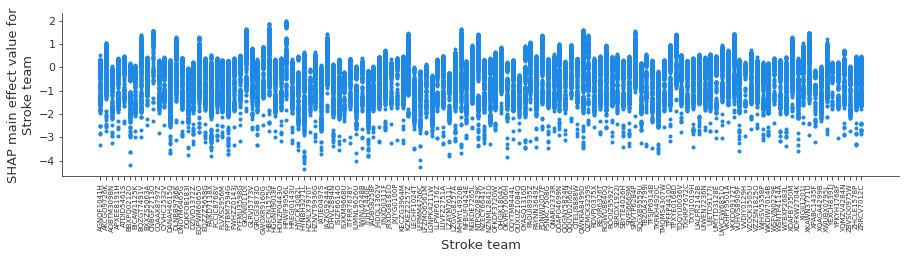

In [47]:
f1 = "Stroke team"
f2 = "Stroke team"

# Add more jitter the fewer categories the feature has
n_categories = X_combined[f1].nunique()
x_jitter = max(0, 0.7 - (n_categories * 0.1))

fig, ax = plt.subplots()

shap.dependence_plot(
    (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
    display_features=X_combined, show=False, ax=ax)

plt.xticks(rotation=90, fontsize=7);
fig.set_figheight(3)
fig.set_figwidth(15)

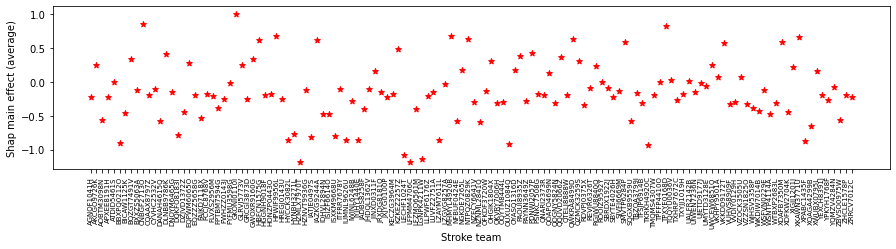

In [48]:
# Stroke team is now summed to be a single feature again
#    But know the stroke team for each instance, so can plot the average main 
#    effect for each stroke team
f1 = "Stroke team"
f2 = "Stroke team"

# Get order number from feature name
i = X_combined.columns.get_loc(f1)
j = X_combined.columns.get_loc(f2)

# One shap value per instance, linked with stroke team
df = pd.DataFrame(shap_interaction_combined[:,i,j], columns=["shap_interaction_values"])
df["Stroke team"] = X_combined[f1].values

# Calc mean SHAP value per stroke team
stroke_team_mean_shap_main = df.groupby('Stroke team', as_index=False)['shap_interaction_values'].mean()

# plot
#ax = stroke_team_mean_shap_main.plot.scatter(x = 'Stroke team', y = 'shap_interaction_values');
#plt.xticks(rotation=90)
fig, ax = plt.subplots();
ax = plt.scatter(x = stroke_team_mean_shap_main['Stroke team'],
                 y = stroke_team_mean_shap_main['shap_interaction_values'],
                 marker="*", facecolor="r");
plt.xlabel("Stroke team")
plt.ylabel("Shap main effect (average)")
plt.xticks(rotation=90, fontsize=7);
fig.set_figheight(3)
fig.set_figwidth(15)

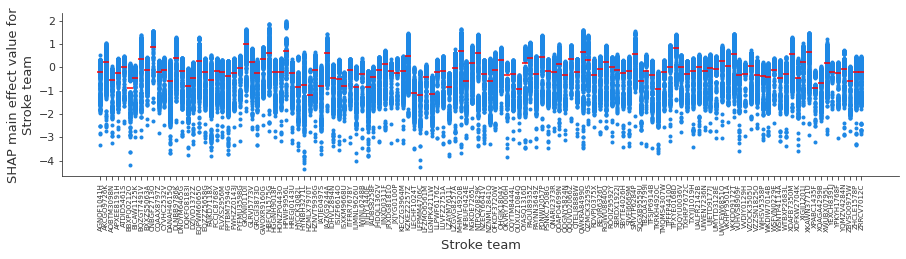

In [49]:
fig, ax = plt.subplots()

shap.dependence_plot(
    (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
    display_features=X_combined, show=False, ax=ax)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax = plt.scatter(x = stroke_team_mean_shap_main['Stroke team'],
                 y = stroke_team_mean_shap_main['shap_interaction_values'],
                 marker="_", facecolor="r");

#plt.xlim(xlim[0],xlim[1])
plt.xlim(xlim)
plt.ylim(ylim)

plt.xticks(rotation=90, fontsize=7);
fig.set_figheight(3)
fig.set_figwidth(15)

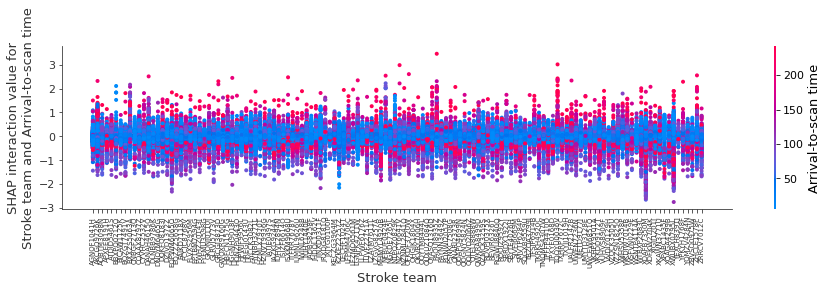

In [50]:
f1 = "Stroke team"
f2 = "Arrival-to-scan time"

# Add more jitter the fewer categories the feature has
n_categories = X_combined[f1].nunique()
x_jitter = max(0, 0.7 - (n_categories * 0.1))

fig, ax = plt.subplots()

shap.dependence_plot(
    (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
    display_features=X_combined, show=False, ax=ax)

plt.xticks(rotation=90, fontsize=7);
fig.set_figheight(3)
fig.set_figwidth(15)

The odd thing seeing here is that the long arrival to scan times (red) contribute to a positive SHAP (more likliehood to give IVT).
We speculate that these points may represent patients with a haemorrhagic stroke, and so the feature value that informs the model that the patient is haemorrhagic overrides the decision to not give IVT, and so these long arrival to scan times are theirs and are not really having an impact on the decision.

Let's investigate.

1) plot the above just for haemorrhagic strokes
2) extract patients with red points (>150 minutes) and high SHAP value (>1) [note: so search for 0.5 as this is what is stored in the shap_interaction_combined, and the grpah shows double to represent the mirrored SHAP interaction).
3) plot waterfall of a extreme red point (e/g the one with SHAP 3).

1) Plot the above just for haemorrhagic strokes.

First extract data for just haemorrhagic strokes

In [51]:
mask = X_combined["Infarction"] == 0
# Get just data for haemorrhagic patients
X_combined_hae = X_combined[mask].copy(deep=True)
# Get just SHAP interactions for haemorrhagic patients
shap_interaction_combined_hae = shap_interaction_combined[mask,:,:]

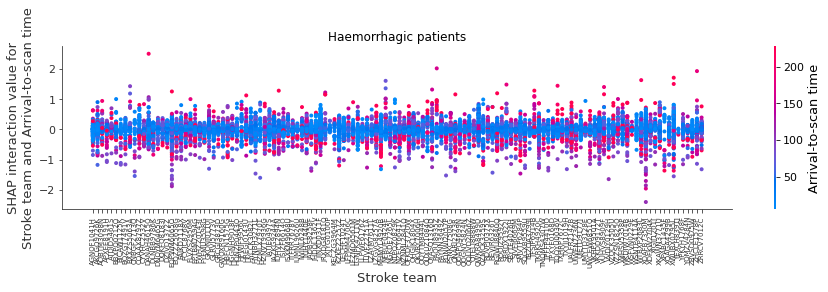

In [52]:
f1 = "Stroke team"
f2 = "Arrival-to-scan time"

# Add more jitter the fewer categories the feature has
n_categories = X_combined[f1].nunique()
x_jitter = max(0, 0.7 - (n_categories * 0.1))

fig, ax = plt.subplots()

shap.dependence_plot(
    (f1, f2), shap_interaction_combined_hae, X_combined_hae, x_jitter=x_jitter, 
    display_features=X_combined_hae, show=False, ax=ax)

plt.xticks(rotation=90, fontsize=7);
plt.title("Haemorrhagic patients")
fig.set_figheight(3)
fig.set_figwidth(15)

Still seeing some patients with a high SHAP for a long arrival-to-scan time within just the ischaemic strokes

2. Extract patients with red points (>150 minutes) and high SHAP value (>1).

In [53]:
f1 = "Stroke team"
f2 = "Arrival-to-scan time"

# mask for the arrival-to-scan time
mask_time = X_combined["Arrival-to-scan time"] >= 150

# location of the two features
f1_loc = X_combined.columns.tolist().index(f1)
f2_loc = X_combined.columns.tolist().index(f2)
                       
# mask for the high SHAP value
mask_shap = shap_interaction_combined[:,f1_loc, f2_loc] >= 0.5#This is equivalent to 1 in the plots (the plots show double to include the mirror SHAP interaction)

# Combine the two masks
mask = mask_shap * mask_time
                       
# Get data for patients with long arrival to scan time, and high SHAP value
X_combined_mask = X_combined[mask].copy(deep=True)
# Get SHAP interactions for patients with long arrival to scan time, and high SHAP value
shap_interaction_combined_mask = shap_interaction_combined[mask,:,:]

Plot Just those patients with long arrival-to-scan times (>150 mins), and high SHAP values (>1)

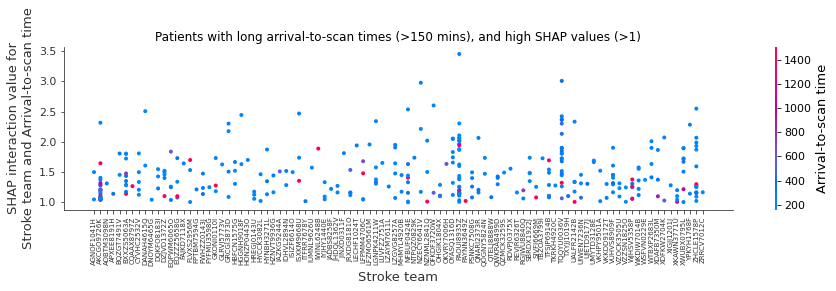

In [54]:
f1 = "Stroke team"
f2 = "Arrival-to-scan time"

# Add more jitter the fewer categories the feature has
n_categories = X_combined[f1].nunique()
x_jitter = max(0, 0.7 - (n_categories * 0.1))

fig, ax = plt.subplots()

shap.dependence_plot(
    (f1, f2), shap_interaction_combined_mask, X_combined_mask, x_jitter=x_jitter, 
    display_features=X_combined_mask, show=False, ax=ax)

plt.xticks(rotation=90, fontsize=7);
plt.title("Patients with long arrival-to-scan times (>150 mins), and high SHAP values (>1)")
fig.set_figheight(3)
fig.set_figwidth(15)

Plot waterfall of the patient with the highest SHAP interaction for Arrival-to-scan time (in the plot this is SHAP 3 with Arrival to Scan > 200 minutes).

In [55]:
# location of the two features
f1_loc = X_combined.columns.tolist().index(f1)
f2_loc = X_combined.columns.tolist().index(f2)

max_shap = shap_interaction_combined[:,f1_loc, f2_loc].max()
location_high_shap_arrival_hosp = shap_interaction_combined[:,f1_loc, f2_loc].argmax()

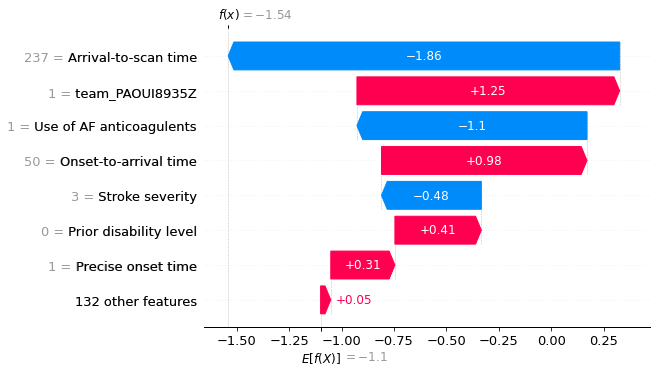

In [56]:
fig = shap.plots.waterfall(
                shap_values[location_high_shap_arrival_hosp],
                show=False, max_display=8)
plt.show()

Realised that the SHAP of 3 for the SHAP interaction of "Stroke team" and "Arrival-to-scan time" is hidden amongst the two features, summed with their main effect and other interactions.

Let's write this instance out.

In [57]:
instance = location_high_shap_arrival_hosp
target_category = ["not thrombolysis", "thrombolysis"]
# Show data for first example
print ('Showing a worked example for the instance with the highest SHAP \n'
       'interaction for the features "Stroke team" and "Arrival-to-scan time"')
print ('==============================================')
print ()
print ('------------------')
print ('Feature data values')
print ('------------------')
print (X_combined.iloc[instance])

# Model output
prob_thrombolysis = y_proba[instance][1]
logodds_thrombolysis = np.log(prob_thrombolysis/(1 -prob_thrombolysis))
print ()
print ('-------------------')
print ('Model output values')
print ('-------------------')
print (f'1. Model probability [not thrombolysis, thrombolysis]: ' +
       f'{np.round(y_proba[instance],3)}')
##print ('------------')
#print (np.round(y_proba[instance],3))
print (f'\n2. Model log odds survive: {round(logodds_thrombolysis,3)}')
#print ('------------')
#print(round(logodds_survive,3))
cat = np.int(y_pred[instance])
print (f'\n3. Model classification: {cat} ({target_category[cat]})')
##print ('------------')
#print (y_pred[instance])

print ()
print ('-----------------')
print ('SHAP base value (log odds)')
print ('---------------')
print (shap_values_combined.base_values[instance])
print ('\nNote: This is the same value for all of the instances. This is the ' +
       'models best guess without additional knowledge about the instance')
 
#example_shap = pd.DataFrame(shap_values.values[instance],columns=X.columns)
print ()
print ('-----------------')
print ('SHAP values (log odds)')
print ('------------')
# print (example_shap)
for i in range(len(shap_values_combined.values[instance])):
    v = shap_values_combined.values[instance][i]
    print (f'{X_combined.columns.values[i]}: {v:0.3f}')
v = shap_values_combined.values[instance].sum()
print (f'Total = {v:0.3f}')

print ('\nNote: These are patient dependent')
#print ()
#print ('-----------------')
#print ('Sum of SHAP values')
#print ('------------')
#print (shap_values.values[instance].sum())

print (f'\nThe "Model log odds thrombolysis" value ({logodds_thrombolysis:0.3g}, ' +
       f'see above) is calculated by adding up the SHAP base value ' +
       f'({shap_values_combined.base_values[instance]:0.3f}, see above) with ' +
       f'all of the SHAP values for each feature ' +
       f'({shap_values_combined.values[instance].sum():0.3f}, see above)')
print (f'{shap_values_combined.base_values[instance]:0.3f} + ' +
       f'{shap_values_combined.values[instance].sum():0.3f} = ' +
       f'{logodds_thrombolysis:0.3f}')

# SHAP interaction values for first employee
example_interaction = pd.DataFrame(shap_interaction_combined[instance],
                                   index=X_combined.columns,
                                   columns=X_combined.columns)
row_total = example_interaction.sum(axis=0)
column_total = example_interaction.sum(axis=1)
total = example_interaction.sum().sum()
example_interaction['Total'] = row_total
example_interaction.loc['Total'] = column_total
example_interaction.loc['Total']['Total'] = total

print ()
print ('-----------------')
print ('SHAP interactions (log odds)')
print ('-----------------')
print ('\n* Each instance has a different SHAP value for the features. This ' +
       'is because the model is also capturing the interaction between pairs ' +
       'of features, and how that contributes to the features SHAP value.')
print ('* Each feature has a SHAP main effect (on the diagonal) and a SHAP ' +
       'interaction effect with each of the other features (off the diagonal)')
print ('* SHAP interaction is split symetrically, eg. age-male is the same ' +
       'as male-age.')
print ('* For each feature, the sum of the SHAP main effect and all of its ' +
       'SHAP interaction values = SHAP value for the feature (shown in ' +
       '"Total", and can be compared to the SHAP values above)')
print ()
print (example_interaction)

print ('------------------')
print ('\nThe model prediction for each instance can be arrived at by ' +
       'starting at the SHAP base value, and adding on the SHAP values from ' +
       'all of the the main effects (one per feature) and from all of the ' +
       'SHAP interactions (two per pair of features).')

Showing a worked example for the instance with the highest SHAP 
interaction for the features "Stroke team" and "Arrival-to-scan time"

------------------
Feature data values
------------------
Arrival-to-scan time             237.0
Infarction                           1
Stroke severity                    3.0
Precise onset time                   1
Prior disability level               0
Stroke team                 PAOUI8935Z
Use of AF anticoagulents             1
Onset-to-arrival time             50.0
Name: 54990, dtype: object

-------------------
Model output values
-------------------
1. Model probability [not thrombolysis, thrombolysis]: [0.823 0.177]

2. Model log odds survive: -1.54

3. Model classification: -1 (thrombolysis)

-----------------
SHAP base value (log odds)
---------------
-1.0995926

Note: This is the same value for all of the instances. This is the models best guess without additional knowledge about the instance

-----------------
SHAP values (log odds)
----------

Plot this individual case on the matrix of dependency plots to show where an individual patient is across all of the main effects and interactions.

(need rather messy code to access the order of the stroke teams on the xticklabels)

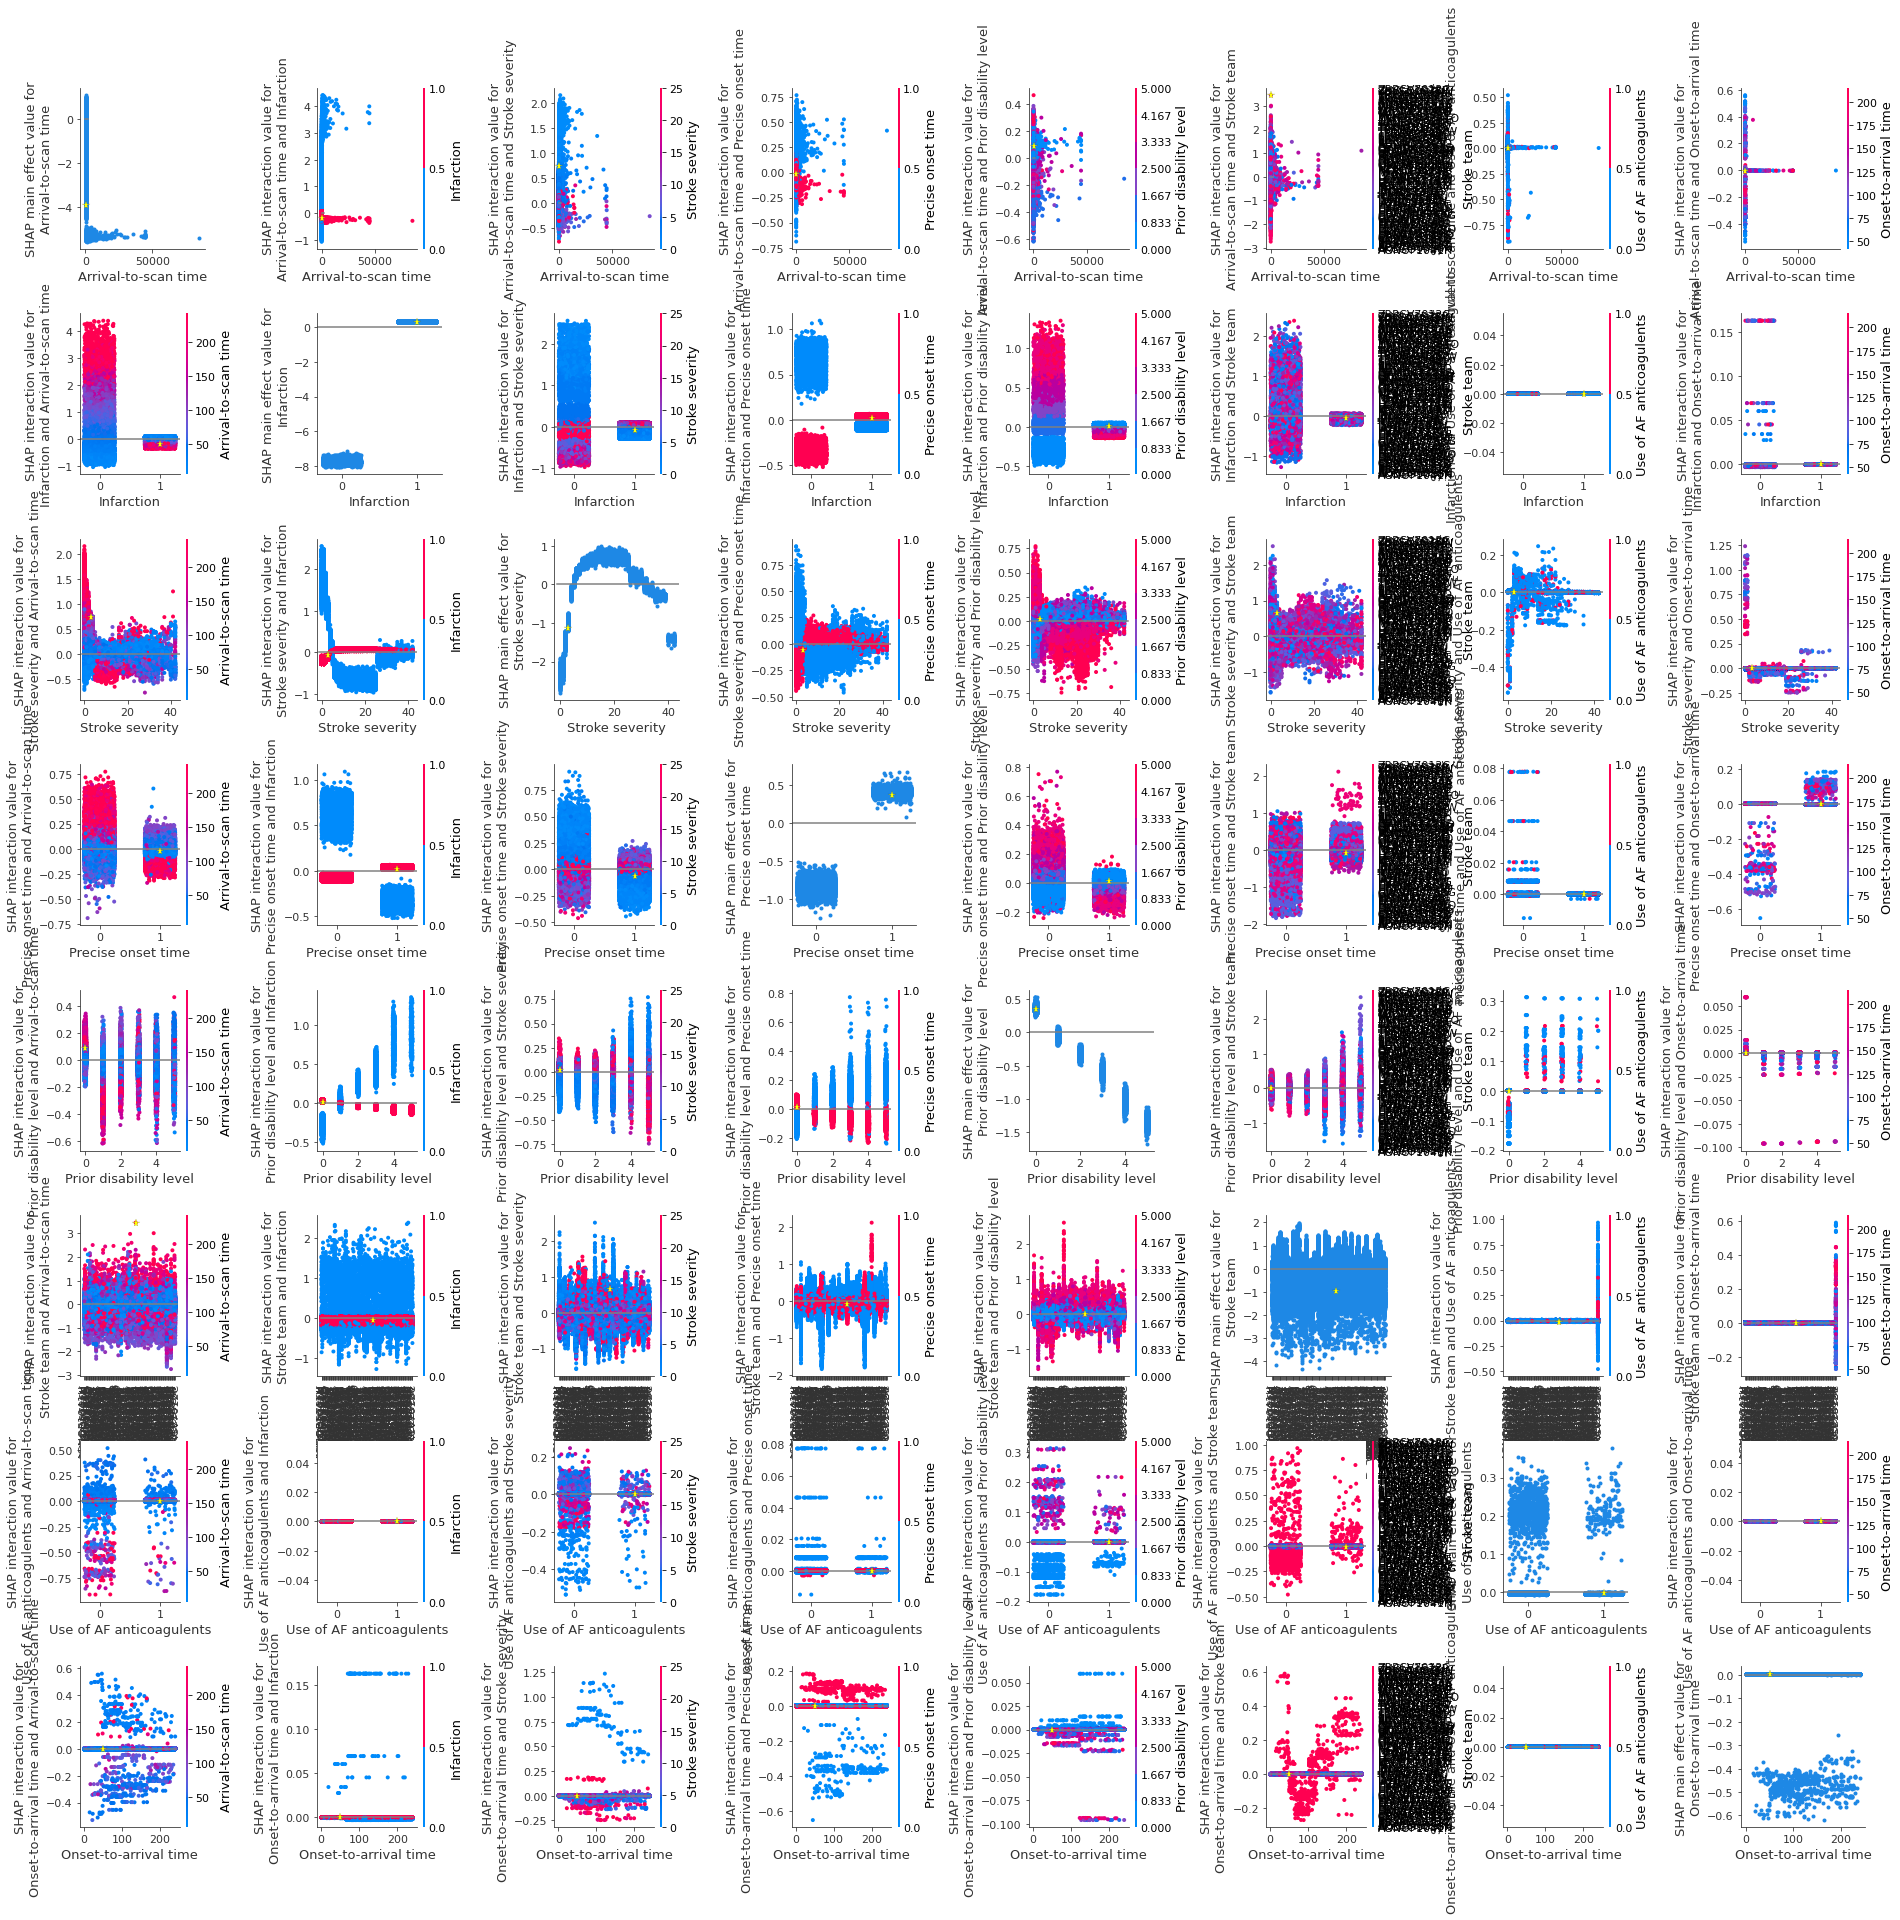

In [58]:
# Individual to highlight on each dependency plot
instance = location_high_shap_arrival_hosp

# Number of features to display
n = n_features

# Get feature names
features = X_combined.columns[0:n]

# Set up the matrix of subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()

# Plot each SHAP independence (and main effect on diagonal)
count = 0
for f1 in features:
    for f2 in features:
        
        # Add more jitter the fewer categories the feature has
        n_categories = X_combined[f1].nunique()
        x_jitter = max(0, 0.7 - (n_categories * 0.1))
            
        # Plot data
        shap.dependence_plot(
            (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
            display_features=X_combined, show=False, ax=axes[count])
        
        # Add line at Shap = 0
        n_classes = X_combined[f1].nunique()
        axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   

        # Add individual patient
        # location of the two features
        f1_loc = X_combined.columns.tolist().index(f1)
        f2_loc = X_combined.columns.tolist().index(f2)
        x = X_combined[f1].iloc[instance]
        y = shap_interaction_combined[instance,f1_loc, f2_loc]
        if f1 != f2:
            # If not main effect, then double shap interaction for the graph
            y = y* 2
            
            
        # If f1 is Stroke team, then need to find the xtick location for the 
        #   corresponding categorical value (the stroke team name). It is not possible 
        #   to plot a mark on the graph using just the stroke team name as a reference - 
        #   need to know how many ticks along it is.
        if f1 == "Stroke team":
            # Initialise x, keep searching til x has tick mark number
            x = -1
            # i is the count along the x tixk labels
            i = 0
            while x == -1:
                # Get x tick label. It is a text object with three parts: 1) location, 
                #   2) ?, 3) stroke name
                xticklabel = str(axes[count].get_xticklabels()[i])
                # Manipulate the "text" object so can access the three parts
                xticklabel = xticklabel.replace(" ", "")
                beginning = xticklabel.find('(')
                xticklabel = xticklabel[beginning:]
                xticklabel = xticklabel.replace("(", "")
                xticklabel = xticklabel.replace(")", "")
                split_xticklabel = xticklabel.split(",")
                # Does the xtick label contain the Stroke team name?
                if split_xticklabel[2].replace("'", "") == (
                                            X_combined["Stroke team"].loc[instance]):
                    # If a match, then store dhte x tick location to plot the mark
                    x = int(float(split_xticklabel[0]))
                else:
                    # If not a match, then move along to the next xtick label
                    i += 1
    
        axes[count].plot(x, y, marker="*", markersize=8, 
                         markeredgecolor="black",
                         markerfacecolor="yellow",
                         markeredgewidth=0.1)
        count += 1
        
        plt.plot
        
# Visual properties of figure
dimension = 4 * n
fig.set_figheight(dimension)
fig.set_figwidth(dimension)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)

plt.savefig('./output/shap_interaction_dependency_plot_one_hosp_feature_single_patient.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)


plt.show()

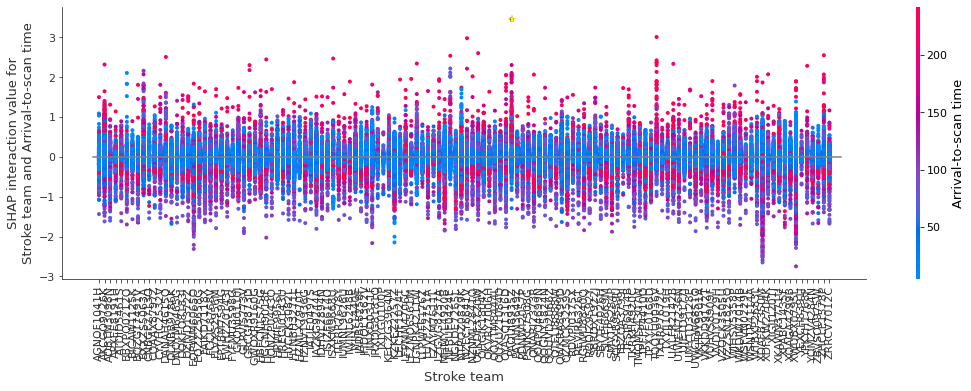

In [59]:
# Individual to highlight on each dependency plot
instance = location_high_shap_arrival_hosp

# Number of features to display
n = n_features

# Get feature names
features = X_combined.columns[0:n]

# Set up the matrix of subplots
fig, axes = plt.subplots(figsize=[18,5])

# Plot each SHAP independence (and main effect on diagonal)
count = 0
f1 = "Stroke team"
f2 = features[0]
        
# Add more jitter the fewer categories the feature has
n_categories = X_combined[f1].nunique()
x_jitter = max(0, 0.7 - (n_categories * 0.1))

# Plot data
shap.dependence_plot(
    (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
    display_features=X_combined, show=False, ax=axes)

# Add line at Shap = 0
n_classes = X_combined[f1].nunique()
axes.plot([-1, n_classes + 1], [0,0],c='0.5')   

# Add individual patient
# location of the two features
f1_loc = X_combined.columns.tolist().index(f1)
f2_loc = X_combined.columns.tolist().index(f2)
x = X_combined[f1].iloc[instance]
y = shap_interaction_combined[instance,f1_loc, f2_loc]
if f1 != f2:
    # If not main effect, then double shap interaction for the graph
    y = y* 2
    
# If f1 is Stroke team, then need to find the xtick location for the 
#   corresponding categorical value (the stroke team name). It is not possible 
#   to plot a mark on the graph using just the stroke team name as a reference - 
#   need to know how many ticks along it is.
if f1 == "Stroke team":
    # Initialise x, keep searching til x has tick mark number
    x = -1
    # i is the count along the x tixk labels
    i = 0
    while x == -1:
        # Get x tick label. It is a text object with three parts: 1) location, 
        #   2) ?, 3) stroke name
        xticklabel = str(axes.get_xticklabels()[i])
        # Manipulate the "text" object so can access the three parts
        xticklabel = xticklabel.replace(" ", "")
        beginning = xticklabel.find('(')
        xticklabel = xticklabel[beginning:]
        xticklabel = xticklabel.replace("(", "")
        xticklabel = xticklabel.replace(")", "")
        split_xticklabel = xticklabel.split(",")
        # Does the xtick label contain the Stroke team name?
        if split_xticklabel[2].replace("'", "") == (
                                    X_combined["Stroke team"].loc[instance]):
            # If a match, then store dhte x tick location to plot the mark
            x = int(float(split_xticklabel[0]))
        else:
            # If not a match, then move along to the next xtick label
            i += 1

axes.plot(x, y, marker="*", markersize=8, 
                 markeredgecolor="black",
                 markerfacecolor="yellow",
                 markeredgewidth=0.1)

plt.plot

plt.show()

Not getting much of a clear story here.

Using this patient as an example. See they have a very high SHAP interaction value (3) for a long Arrival to scan time (237 minutes) attending hospital PA.
I thoguht that maybe this was because the hospital iself was very por IVT and so the interation of the long time with this hospital meant that it could still have a positive influence. However the main effect for the stroke team for this patient is  -0.970265 . So reduces teh likelihood for IVT.

Let's look at the SHAP value and SHAP main effect for all patients that attend hospital PA. Did that in notebook 3c.

In [77]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    return()

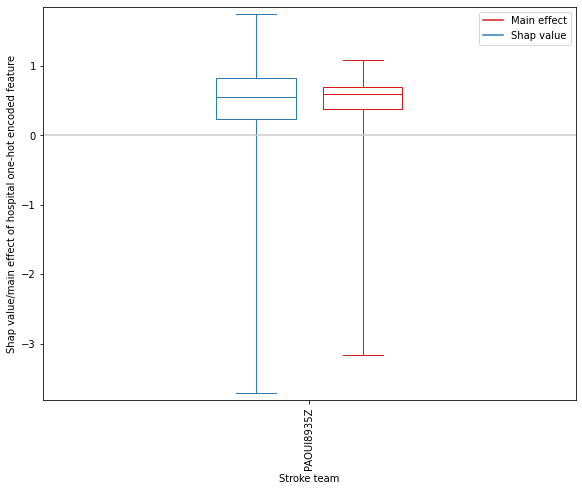

In [86]:
hospital = X_combined["Stroke team"].loc[instance]
mask_attend_hosptial = X_combined["Stroke team"] == hospital
f_loc = X_combined.columns.tolist().index("Stroke team")
main_effect = shap_interaction_combined[mask_attend_hosptial,f_loc,f_loc]
shap_value = shap_interaction_combined[mask_attend_hosptial,f_loc,:].sum(axis=1)

# Use overall y min and max of both datasets on the 4 plts so have a unified scale
#https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.
ymin = min(shap_value)
ymax = max(shap_value)

yrange = ymax - ymin

ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
# "The contribution from this hospital when patients do not attend this hosptial"

ticks = [hospital]

pos_sv = np.array(range(1))*2.0-0.4
bp_sv = plt.boxplot(shap_value, 
                    positions=pos_sv, sym='', whis=99999, widths=0.6)

pos_me = np.array(range(1))*2.0+0.4
bp_me = plt.boxplot(main_effect, 
                    positions=pos_me, sym='', whis=99999, widths=0.6)

set_box_color(bp_me, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp_sv, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Main effect')
plt.plot([], c='#2C7BB6', label='Shap value')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(ymin, ymax)
plt.tight_layout()

# Add line at Shap = 0
plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 

plt.ylabel('Shap value/main effect of hospital one-hot encoded feature',size=10)
plt.xlabel('Stroke team',size=10)
plt.xticks(rotation=90)
plt.show()
st = min(st+inc,max_size)
ed = min(ed+inc,max_size)

Use own waterfall code to show SHAP interations (not just SHAP values)

From logistic_regression_single_fit_shap_waterfall_subplots.ipynb

In [ ]:
def waterfall_plot(chosen_instance, shap_values_instance, expected_value, 
                   predicted_value, max_display=10, style_arrows=False,
                   ax=None, title=None, **kwargs):
#                   min_contribute=0):
    """
    STILL NEED TO IMPROVE THIS FUNCTION SO THAT LABEL PLACEMENT ON THE PLOT, AND PLOT SIZE ADJUSTMENT WORKS FOR ALL PLOT SIZES
    THE CODE THAT NEEDS ADJUSTING IS MARKED WITH #***
    
    chosen_instance: [pandas dataframe] the index is feature name, value is 
                     feature value for instance
    shap_values_instance: [numpy array] the shapley values for each feature for 
                          the instance
    expected_value: [float] the output value that is expected for the dataset 
                    (e.g. median)
    predicted_value: [float] the predicted output for the instance
    max_display: [integer] the number of features to include in the waterfall
                  plot. If nothing is passed, the top 10 features are plotted (or the max)
    style_arrows: [boolean] whether to display as a horizontal bar chart 
                  (False), or using arrows (True)
    ax=None: []
    title=None: []
    **kwargs: []

NOT USED ATM
    set_show: [boolean] set to false when creating a subplot (default is True)
    min_contribute: [float] only features that contribute at least this amout will be on the graph. If nothing is passed, 
                all features are plotted
    """
    
    if title==None:
        title = "The effects of each feature for the prediction of a single instance"

# KP TO DO. COMBINE THE REQUEST OF MAX_DISPLAY AND MIN_CONTRIBUTE

#    if min_contribute > 0:
#        mask = shap_values_instance > min_contribute
#        chosen_instance = chosen_instance[mask]
#        shap_values_instance = shap_values_instance[mask]
#        expected_value = expected_value[mask]
    

    # set up pandas dataframe with the data required for the waterfall chart
    data = pd.DataFrame(chosen_instance)
    data.columns = ["instance"]
    data["shap"] = shap_values_instance
    data["shap_absolute"] = np.abs(shap_values_instance)
    
    # limit the number of features to display to the number available
    max_display = min(max_display, data.shape[0])

    # if max_display not passed, set to total number of features available
    if max_display == -1:
        max_display = data.shape[0]
        
    # sort the rows on the absolute shapley values (smallest value at top)
    data = data.sort_values(by=["shap_absolute"], 
                                      ascending=True)

    # if want to display fewer features than the full set
    if max_display < data.shape[0]:

        # select features ranked by most influence
        waterfall_plot = data.tail(max_display)    

        # represent the remaining features as one row
        waterfall_plot_remaining = data.iloc[0:-max_display]
        summary_remaining = pd.DataFrame(
                                    columns=waterfall_plot_remaining.columns)
        summary_remaining["instance"] = [np.nan]
        summary_remaining["shap"] = [waterfall_plot_remaining.shap.sum()]
        summary_remaining["shap_absolute"] = (
                                [np.abs(waterfall_plot_remaining.shap.sum())])
        index_title = f"remaining_{waterfall_plot_remaining.shape[0]}_features"
        summary_remaining.index = [index_title]
        waterfall_plot = summary_remaining.append(waterfall_plot)

    else:
        waterfall_plot = data.copy(deep=True)
        
    # create two new columns containing the x coordinates for the lhs and rhs of
    # each bar    
    # one side of the first bar is the expected value plus the bar's shapley 
    # value. The remaining bars take as one side the culmulative sum of the
    # shapley values and the expected value.
    shap_series = waterfall_plot.shap.copy(deep=True)
    shap_series[0] = shap_series[0] + expected_value#explainer.expected_value
    shap_cumsum = shap_series.cumsum()

    # the other side of each bar is the value from the previous bar (for the 
    # first bar, this is the expected value)
    shap_cumsum_prev = shap_cumsum.copy(deep=True)
    shap_cumsum_prev[1:] = shap_cumsum_prev[0:-1]
    shap_cumsum_prev[0] = expected_value#explainer.expected_value

    # the shapley values can be either sign, so the LHS is the min of both
    # series, and the RHS is the max of both series
    # add these to the waterfall_plot DataFrame
    lhs_bar = pd.DataFrame([shap_cumsum_prev, shap_cumsum]).min()
    rhs_bar = pd.DataFrame([shap_cumsum_prev, shap_cumsum]).max()
    waterfall_plot["lhs_bar"] = lhs_bar
    waterfall_plot["rhs_bar"] = rhs_bar
    
    model_predict = shap_cumsum[-1]

    # add the expected and predicted value for this instance to the DataFrame

    # 220117 removed for now as they can be in different units: log-odds and probability
#    abs_diff = np.abs(model_predict-predicted_value)
#    if abs_diff > 0.000001:
#        print(f"There is a difference between the predicted value from the model"
#              f" and the culmulative sum of the shapley values: {abs_diff}")

    model_predict = np.repeat(model_predict, waterfall_plot.shape[0])
    waterfall_plot["model_predict"] = model_predict    
#    exp_value = np.repeat(explainer.expected_value, waterfall_plot.shape[0])
    exp_value = np.repeat(expected_value, waterfall_plot.shape[0])
    waterfall_plot["expected_value"] = exp_value
        
    # the plot will show blue for positive shapley value, and red for negative
    c = waterfall_plot.shap.copy(deep = True)
    mask_lt = c < 0
    mask_gt = c >= 0
    c[mask_lt] = "crimson"#"r"
    c[mask_gt] = "dodgerblue"#"b"
    waterfall_plot["bar_colour"] = c
    
    # set up other parameters for the waterfall plot:
    # number of features
    n_features = waterfall_plot.shape[0]
    # positions for the y axis items
    pos = np.arange(0.5, n_features * 0.5 + 0.5, 0.5)
    # labels for the y axis (feature name and feature value)
    labels = waterfall_plot.index.astype(str) + " (" + waterfall_plot.instance.round(3).astype(str) + ")"
    
    # CONSTANTS TO ADJUST AXIS RANGE AND LABEL POSITIONS
    # find the range of the x axis, so can use this to determine the constants 
    # to use in order to place the labels on the graph
    x_axis_min = lhs_bar.min()
    x_axis_max = rhs_bar.max()
    x_axis_range = abs(x_axis_min) + abs(x_axis_max)
    
    # constant to use for the lhs label
#    lhs_label_adjustment = 3/x_axis_range
    lhs_label_adjustment = x_axis_range/10 #45
    # constant to use for the rhs label
#    rhs_label_adjustment = 0.5/x_axis_range
    rhs_label_adjustment = x_axis_range/80
    # constant to use for the lhs x_lim for axis
    #x_left*1.05
    x_axis_lhs_adjustment = 0.8
    if x_axis_min < 0:
        x_axis_lhs_adjustment = 1.2
    
    # constant to use for the rhs x_lim for axis
    #x_right*0.95
    x_axis_rhs_adjustment = 1.2
    if x_axis_max < 0:
        x_axis_rhs_adjustment = 0.8

    ### ### ### create the plot ### ### ###
    
    # set size of plot (width is constant, height is based on number of features)
    if ax==None:
        fig = plt.figure(figsize=(5, 0.4 * (max_display + 1)))
        ax1 = fig.add_subplot(111)
    else:
        ax1 = ax    
        ax1.set_width = 8
        ax1.set_height =  0.4 * (max_display + 1)

    # for each feature of the model create a horizontal bar
    for i in range(n_features):
        
        # get the position for the bar
        lhs_bar = waterfall_plot.lhs_bar.iloc[i]
        rhs_bar = waterfall_plot.rhs_bar.iloc[i]

        # allocate colour (based on sign of shapley value)
        colour = waterfall_plot.bar_colour.iloc[i]

        if style_arrows:
            # create plot with arrows
            
            # direction of the arrow depends on the sign of the shapley value
            if waterfall_plot.shap.iloc[i] < 0:
                x_tail = rhs_bar
                x_head = lhs_bar
            else:
                x_tail = lhs_bar
                x_head = rhs_bar

            # height of arrow the same regardless of sign of shapley value
            y_tail = (i * 0.5) + 0.5
            y_head = (i * 0.5) + 0.5
            
            # create arrow
            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), 
                                             (x_head, y_head),
                                              mutation_scale=10,
                                              color = colour,
                                              ec = colour)
            # plot arrow
            ax1.add_patch(arrow)

        else: 
            # create plot with bars
            ax1.barh((i * 0.5) + 0.5, 
                     rhs_bar - lhs_bar, 
                     left = lhs_bar, 
                     height = 0.3, 
                     align = 'center', 
                     edgecolor = colour, 
                     color = colour, 
                     alpha = 0.8)


        # add text (the shapley value) to each bar
        # location depends on sign of shapley value
        
            #*** THE ADJUSTMENTS HERE (CONSTANTS FOR text_xaxis and test_yaxis)
            #*** NEED TO BE DONE A DIFFERENT WAY. AT THE MOMENT NEED TO CHANGE
            #*** AND CUSTOMISE FOR EACH GRAPH DEPENDING OF GRAPH SIZE
        if waterfall_plot.shap.iloc[i] < 0:
            text_xaxis = lhs_bar - lhs_label_adjustment
        else:
            text_xaxis = rhs_bar + rhs_label_adjustment
        text_yaxis = (i * 0.5) + 0.4

        ax1.text(text_xaxis, 
                 text_yaxis,
                 str(round(waterfall_plot.shap.iloc[i], 2)), 
                 fontsize=8,
                 color=colour)

    # expand xlim and ylim to make labels easier to read

        #*** THE ADJUSTMENTS HERE (CONSTANTS FOR set_ylim and set_xlim)
        #*** NEED TO BE DONE A DIFFERENT WAY. AT THE MOMENT NEED TO CHANGE
        #*** AND CUSTOMISE FOR EACH GRAPH DEPENDING OF GRAPH SIZE, AND ALSO 
        #*** FOR WHETHER THE X AXIS IS + or - AT IT'S EXTREMES
        
    ax1.set_ylim(0,np.max(pos)*1.02)
    x_left, x_right = ax1.get_xlim()
#    ax1.set_xlim(x_left*1.05, x_right*0.95)
    ax1.set_xlim(x_left*x_axis_lhs_adjustment, 
                 x_right*x_axis_rhs_adjustment)
 
    x_left, x_right = ax1.get_xlim()
    
    #convert values into axis units so the arrow points to the right place
    expected_value_xaxis = ((waterfall_plot.expected_value[0] -x_left) / 
                            (x_right - x_left))
    model_predict_xaxis = ((waterfall_plot.model_predict[0] -x_left) / 
                           (x_right - x_left))

    # set properties for the arrow
    arrow_args = dict(arrowstyle="->")

    # annotate the expected value on the bottom of the x axis
    ax1.annotate(f'E[f(x)] = {waterfall_plot.expected_value[0].round(3)}', 
                 xy=(expected_value_xaxis, 0), 
                 xycoords='axes fraction',
                 xytext=(-70, -40), 
                 textcoords='offset points',
                 ha="left", va="bottom",
                 arrowprops=arrow_args)

    # annotate the predicted value on the top of the x axis
    ax1.annotate(f'f(x)= {waterfall_plot.model_predict[0].round(3)}', 
                 xy=(model_predict_xaxis, 1), 
                 xycoords='axes fraction',
                 xytext=(-80, 20), 
                 textcoords='offset points',
                 ha="left", va="bottom",
                 arrowprops=arrow_args)

    ax1.set_yticks(pos)
    ax1.set_yticklabels(labels)
    ax1.set_title(title)#'Shapley values for each feature for a single instance')

    return(ax1)

In [ ]:
### Using the waterfall_plot function to create a single graph

In [ ]:
instance = location_low_probability
chosen_instance = X_test.iloc[instance]
shap_values_instance = shapley_values_test[instance]
expected_value = shapley_values_test_extended.base_values[0]
chosen_predict = y_probs[instance]

waterfall_plot(chosen_instance, 
               shap_values_instance, 
               expected_value,
               chosen_predict)

# Save plot
output_path = './output/'
plt.savefig(output_path + 'waterfall_solo_plot.png', dpi=300)

# Show plot
plt.show()

In [ ]:
f1 = "Arrival-to-scan time"
f2 = "Stroke team"

# Add more jitter the fewer categories the feature has
n_categories = X_combined[f1].nunique()
x_jitter = max(0, 0.7 - (n_categories * 0.1))

fig, ax = plt.subplots()

shap.dependence_plot(
    (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
    display_features=X_combined, show=False, ax=ax)
plt.xticks(rotation=90, fontsize=11);

fig.set_figheight(10)
fig.set_figwidth(10)
#plt.rcParams.update({'font.size': 22})

Using the individual instance values you can unpick and understand how each instance gets their classification.

Each instance is represented in the grid of SHAP depencency plots, and so this shows all of the relationships that the model uses to derive it's predictions for the whole dataset. 

## Other SHAP plotting options

The SHAP library also offers other plotting options, such as a summary plot based on the beeswarm plot. 

We will show it here for completeness, however we found it to be tricky to interprete, and left gaps in our understanding of the relationships (it left us with further questions). 

It was due to this that we created our grid of dependency plots (as displayed above).

### SHAP interactions summary plot (a grid of beeswarms)

The beeswarm plot above showed the overall SHAP value for the feature. This next plot (a grid of beeswarms) shows the SHAP main effect and SHAP interactions for each feature. Each row and column represents a feature. The beeswarms on the diagonal represent the SHAP main effect for that feature, and those off the diagonal represent the SHAP interations with the other features.


The graphs are symmetrical around the diagonal, and so the shape of the data in the corresponding graph about the diagonal are the same, however the points are coloured based on the value of the feature represented by the row. For example, the first row this showing the feature male, so red represents the value male, and blue represents the value female. The second row shows the feature Pclass where blue represents first class, purple represents second class, and red represents third class. The third row shows the feature Age where blue represents the youngest, purple represent middle aged and red represents oldest. The fourth row shows the feature SibSp where blue represents no siblings, purple represents 3-4 siblings, and red represents seven siblings.

The shape of the data is based on the density of points that have the SHAP interaction value as displayed on the x axis. 

In [ ]:
#Display summary plot
shap.summary_plot(shap_interaction_combined, X_combined, show=False, max_display=8)

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.